
# 08_UNI2-h ➜ Adapter (gelé) ➜ PixCell-256 + LoRA (UNet)

**But** : réduire le *domain shift* observé sur les embeddings (UNI2‑h, PathoDuet) en adaptant légèrement la pipeline PixCell via :
- un **Adapter** MLP (projection/pack de l’embedding UNI2‑h en quelques tokens de contexte) ;
- des **LoRA** légères injectées uniquement dans les **cross‑attentions** du **UNet** (PixCell).

**Principe** :  
UNI2‑h est gelé et fournit un vecteur de conditionnement `z_uni`. On monkey‑patch la pipeline sans toucher aux poids de base : on concatène les tokens projetés par l'adapter aux `encoder_hidden_states` (texte) consommés par les cross‑attn, et on n’entraîne que l’adapter + les matrices basses‑rangs (LoRA).

> ⚠️ Le *monkey patch* est central : on n’altère pas la signature publique de la pipeline, on accroche un hook propre à `_encode_prompt` (SD‑like) et on append nos tokens.  
> ⚠️ Paramétrage délicat → toutes les dimensions sensibles sont factorisées dans une seule section de config.


## ⚙️ Cell 1 — Imports, device, utilitaires

In [1]:
# %%
import os, math, random, json, time, gc
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from diffusers import DiffusionPipeline, AutoencoderKL
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.models.attention_processor import LoRAAttnProcessor2_0
from PIL import Image
import numpy as np

# Sécurité : CUDA fp16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float16  # fp16 partout où possible
GEN_SEED = 123
torch.manual_seed(GEN_SEED)
torch.cuda.manual_seed_all(GEN_SEED)

print("Device:", device)


Device: cuda


## 📦 Cell 2 — Charger PixCell-256 (+ VAE SD3.5)

In [2]:
# === Cellule 2 — Chargement PixCell + VAE + mise sur GPU/dtype ===
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

device = torch.device("cuda")
DTYPE = torch.float16  # bf16 si tu préfères

# VAE SD3 (recommandé par les auteurs)
sd3_vae = AutoencoderKL.from_pretrained(
    "stabilityai/stable-diffusion-3.5-large",
    subfolder="vae",
    torch_dtype=DTYPE,
)

pipe = DiffusionPipeline.from_pretrained(
    "StonyBrook-CVLab/PixCell-256",
    vae=sd3_vae,
    custom_pipeline="StonyBrook-CVLab/PixCell-pipeline",
    trust_remote_code=True,
    torch_dtype=DTYPE,
)

# Envoi sur GPU (PixCell utilise un TRANSFORMER, pas de .unet ici)
pipe.to(device)
pipe.vae.to(device, dtype=DTYPE)
pipe.transformer.to(device, dtype=DTYPE)

# (Optionnel) Mémoire
# pipe.enable_vae_slicing()
# pipe.enable_model_cpu_offload()


Keyword arguments {'trust_remote_code': True} are not expected by PixCellPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

The config attributes {'double_self_attention': False, 'num_vector_embeds': None, 'only_cross_attention': False, 'use_linear_projection': False} were passed to PixCellTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'flow_shift': 1.0, 'use_flow_sigmas': False} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


PixCellTransformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(16, 1152, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-27): 28 x BasicTransformerBlock(
      (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=1152, out_features=1152, bias=True)
        (to_k): Linear(in_features=1152, out_features=1152, bias=True)
        (to_v): Linear(in_features=1152, out_features=1152, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=1152, out_features=1152, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=1152, out_features=1152, bias=True)
        (to_k): Linear(in_features=1152, out_features=1152, bias=True)
        (to_v): Linear(in_features=1152, out_features=1152, bias=True)
        (to_out): M

## 🩹 Monkey-patch PixArt (resolution / aspect_ratio)

In [3]:
# %% — Monkey patch PixArt: rendre 'resolution' et 'aspect_ratio' optionnels
import types, torch
try:
    from diffusers.models.embeddings import PixArtAlphaCombinedTimestepSizeEmbeddings
except Exception:
    PixArtAlphaCombinedTimestepSizeEmbeddings = None

def patch_pixart_size_modules(pipe, default_res=256, default_ar_times_1000=1000):
    """
    Patche tous les modules PixArtAlphaCombinedTimestepSizeEmbeddings du transformer :
    - si 'resolution' / 'aspect_ratio' manquent, on injecte des valeurs par défaut.
    - 'resolution' = 256 ; 'aspect_ratio' = 1.0 encodé en 1000 (entier), par défaut.
    """
    dev = next(pipe.transformer.parameters()).device
    n = 0

    if PixArtAlphaCombinedTimestepSizeEmbeddings is None:
        raise RuntimeError("Impossible d'importer PixArtAlphaCombinedTimestepSizeEmbeddings (version diffusers incompatible ?)")

    for name, mod in pipe.transformer.named_modules():
        if isinstance(mod, PixArtAlphaCombinedTimestepSizeEmbeddings):
            orig_forward = mod.forward

            def forward_patched(self, timestep, resolution=None, aspect_ratio=None, *args, **kwargs):
                # Déterminer taille de batch
                if isinstance(timestep, torch.Tensor) and timestep.ndim > 0:
                    B = timestep.shape[0]
                    d = timestep.device
                else:
                    B = 1
                    d = dev

                # Resolution -> tensor long (B,1)
                if resolution is None:
                    resolution = torch.full((B, 1), int(default_res), dtype=torch.long, device=d)
                elif not isinstance(resolution, torch.Tensor):
                    resolution = torch.full((B, 1), int(resolution), dtype=torch.long, device=d)

                # Aspect ratio -> entier "milli-AR" (B,1)
                if aspect_ratio is None:
                    aspect_ratio = torch.full((B, 1), int(default_ar_times_1000), dtype=torch.long, device=d)
                elif not isinstance(aspect_ratio, torch.Tensor):
                    # si float -> multiplie par 1000 et arrondit
                    val = int(aspect_ratio) if isinstance(aspect_ratio, int) else int(round(float(aspect_ratio) * 1000))
                    aspect_ratio = torch.full((B, 1), val, dtype=torch.long, device=d)

                return orig_forward(timestep, resolution, aspect_ratio, *args, **kwargs)

            mod.forward = types.MethodType(forward_patched, mod)
            n += 1

    print(f"[patch] PixArt size embedders patchés: {n}")
    if n == 0:
        raise RuntimeError("Aucun module PixArtAlphaCombinedTimestepSizeEmbeddings trouvé à patcher.")
    return n

# ➜ Appliquer le patch
_ = patch_pixart_size_modules(pipe, default_res=256, default_ar_times_1000=1000)


[patch] PixArt size embedders patchés: 1


In [4]:
# B = taille de batch des UNI (1 si tu fais une image à la fois)
B = 1
neg = pipe.get_unconditional_embedding(B)  # (B, N, D)

# Exemple d’appel (pos: tes UNI2-h) :
# out = pipe(uni_embeds=pos, negative_uni_embeds=neg, guidance_scale=1.5)


In [5]:
# ========= LoRA "v3" sur TRANSFORMER PixCell : zéro récursion, zéro modules dans trainable =========
import math, types, torch, torch.nn as nn
import torch.nn.functional as F

RANK, ALPHA = 16, 32  # Rank augmenté (8→16) pour plus de capacité d'apprentissage, alpha proportionnel (16→32)
# Avec les LR réduits (5e-6 pour LoRA), l'augmentation du rank devrait être plus stable

def _patch_linear_with_lora_params(linear: nn.Linear, r=8, alpha=16):
    """
    Patch in-place un nn.Linear avec LoRA (A,B en nn.Parameter uniquement, pas de sous-modules).
    y = W x + (B @ (A @ x)) * (alpha/r)
    Idempotent: si déjà patché, renvoie la liste [A, B] existants.
    Retour: [nn.Parameter, nn.Parameter]
    """
    if hasattr(linear, "lora_A") and hasattr(linear, "lora_B") and hasattr(linear, "lora_scaling"):
        # Déjà patché
        return [linear.lora_A, linear.lora_B]

    in_f, out_f = linear.in_features, linear.out_features
    dev, dt = linear.weight.device, linear.weight.dtype

    # A: (r, in_f) ; B: (out_f, r)
    A = torch.empty(r, in_f, device=dev, dtype=dt)
    B = torch.zeros(out_f, r, device=dev, dtype=dt)
    nn.init.kaiming_uniform_(A, a=math.sqrt(5))
    # B=0 -> sortie identique au modèle de base au départ

    # Enregistre UNIQUEMENT des Parameters & Buffers (pas de sous-modules)
    linear.register_parameter("lora_A", nn.Parameter(A, requires_grad=True))
    linear.register_parameter("lora_B", nn.Parameter(B, requires_grad=True))
    linear.register_buffer("lora_scaling", torch.tensor(float(alpha)/float(r), device=dev))

    # (Optionnel) on peut geler weight si tu veux, mais pas nécessaire:
    # linear.weight.requires_grad = False

    # Patch forward local, sans créer de cycle
    if not hasattr(linear, "_forward_orig"):
        linear._forward_orig = linear.forward

    def _forward_lora(self, x):
        base = self._forward_orig(x)
        # F.linear(x, weight) attend weight [out, in]
        lora = F.linear(F.linear(x, self.lora_A), self.lora_B) * self.lora_scaling
        return base + lora

    linear.forward = types.MethodType(_forward_lora, linear)

    # Retourne STRICTEMENT les Parameters à entraîner
    return [linear.lora_A, linear.lora_B]


def _maybe_get(module: nn.Module, name: str):
    return getattr(module, name) if hasattr(module, name) else None


def inject_lora_pixcell_transformer_v3(pipe, rank=8, alpha=16):
    """
    Zéro parcours récursif: on cible la structure standard des blocs DiT/PixArt.
    Injecte les LoRA UNIQUEMENT dans les cross-attentions (attn2) qui consomment encoder_hidden_states.
    On ne renvoie QUE des nn.Parameter (A & B), jamais de modules.
    """
    assert hasattr(pipe, "transformer"), "pipe.transformer absent"
    t = pipe.transformer

    # Localiser la liste de blocs sans recursion
    blocks = _maybe_get(t, "blocks") \
          or _maybe_get(t, "transformer_blocks") \
          or _maybe_get(t, "layers")

    if blocks is None or not isinstance(blocks, nn.ModuleList) or len(blocks) == 0:
        # Dernier recours: prendre le premier ModuleList enfant direct
        blocks = None
        for child in list(t.children()):
            if isinstance(child, nn.ModuleList) and len(child) > 0:
                blocks = child
                break
    if blocks is None:
        raise RuntimeError("Impossible de localiser la liste de blocs du transformer PixCell.")

    trainable = []
    n_lin = 0

    # Parcours NON récursif des blocs
    # IMPORTANT: ne patcher que attn2 (cross-attention) qui utilise encoder_hidden_states
    # attn1 est la self-attention (sur les tokens d'image) → ne pas adapter
    for blk in blocks:
        # Uniquement cross-attention (attn2) qui consomme les embeddings UNI
        attn = _maybe_get(blk, "attn2")
        if attn is None:
            continue

        # linears: to_q, to_k, to_v (dans cross-attention uniquement)
        for proj_name in ("to_q", "to_k", "to_v"):
            proj = _maybe_get(attn, proj_name)
            if isinstance(proj, nn.Linear):
                params = _patch_linear_with_lora_params(proj, r=rank, alpha=alpha)
                # Filtrage strict: ne garder que des nn.Parameter
                params = [p for p in params if isinstance(p, nn.Parameter)]
                trainable.extend(params)
                n_lin += 1

        # to_out: Linear ou Sequential(Linear, …) (dans cross-attention uniquement)
        to_out = _maybe_get(attn, "to_out")
        if isinstance(to_out, nn.Linear):
            params = _patch_linear_with_lora_params(to_out, r=rank, alpha=alpha)
            params = [p for p in params if isinstance(p, nn.Parameter)]
            trainable.extend(params)
            n_lin += 1
        elif isinstance(to_out, nn.Sequential) and len(to_out) > 0 and isinstance(to_out[0], nn.Linear):
            params = _patch_linear_with_lora_params(to_out[0], r=rank, alpha=alpha)
            params = [p for p in params if isinstance(p, nn.Parameter)]
            trainable.extend(params)
            n_lin += 1

    # ⇩⇩ Filtrage final (sécurité) : on écarte tout ce qui n’est pas nn.Parameter
    trainable = [p for p in trainable if isinstance(p, nn.Parameter)]

    total = sum(p.numel() for p in trainable)
    print(f"[LoRA] Patch (v3) sur {n_lin} Linear de CROSS-ATTENTION (attn2 uniquement). Params LoRA entraînables: {total:,}")
    return trainable


# --- Appel propre (après rechargement pipe pour repartir clean si besoin) ---
lora_params = inject_lora_pixcell_transformer_v3(pipe, rank=RANK, alpha=ALPHA)

# Optimiseur: on n’entraîne QUE les LoRA (A & B)
optimizer = torch.optim.AdamW(lora_params, lr=5e-5, weight_decay=0.0)
print("Nb tensors LoRA entraînables:", len(lora_params))


[LoRA] Patch (v3) sur 84 Linear de CROSS-ATTENTION (attn2 uniquement). Params LoRA entraînables: 3,096,576
Nb tensors LoRA entraînables: 168


In [6]:
# 1) Vérifier qu’on n’a QUE des Parameters
assert all(isinstance(p, nn.Parameter) for p in lora_params)

# 2) Vérifier qu’ils reçoivent du gradient sur un mini-forward
# (ici, on teste juste une passe pipeline avec pos/neg UNI factices)
with torch.no_grad():
    B = 1
    neg = pipe.get_unconditional_embedding(B)
# pos = ton embedding UNI2-h (après adapter si tu l’utilises)
# imgs = pipe(uni_embeds=pos, negative_uni_embeds=neg, guidance_scale=1.2, num_images_per_prompt=1).images


## 🧠 Cell 3 — Charger UNI2-h (timm) + transforms

In [7]:
from huggingface_hub import login
import os

HF_TOKEN = os.getenv("HF_TOKEN")
# Vérifie qu'il est chargé (ne jamais l'afficher publiquement)
assert HF_TOKEN is not None, "HF_TOKEN n'est pas défini dans l'environnement !"

In [8]:
# %%
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

timm_kwargs = {
    'img_size': 224, 
    'patch_size': 14, 
    'depth': 24,
    'num_heads': 24,
    'init_values': 1e-5, 
    'embed_dim': 1536,
    'mlp_ratio': 2.66667*2,
    'num_classes': 0, 
    'no_embed_class': True,
    'mlp_layer': timm.layers.SwiGLUPacked, 
    'act_layer': torch.nn.SiLU, 
    'reg_tokens': 8, 
    'dynamic_img_size': True
}

# Nécessite HF_TOKEN dans l'env
uni_model = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
uni_model.eval().to(device)

cfg = resolve_data_config(uni_model.pretrained_cfg, model=uni_model)
uni_transform = create_transform(**cfg)

print("UNI2-h OK.")


UNI2-h OK.


## 🧩 Cell 4 — Extraction robuste d’embeddings UNI 
## 🔌 Helper pos/neg (uni_embeds_for_pixcell, uni_pos_neg_from_pils)

In [9]:
# %%  — Cellule 4 : UNI2-h → embeddings pour PixCell (B, 1, 1536)
from torchvision import transforms as T
import torch.nn.functional as F

to_pil = T.ToPILImage()

@torch.inference_mode()
def uni_embeds_for_pixcell(pils: list[Image.Image]) -> torch.Tensor:
    """
    Entrée : liste de PIL RGB
    Sortie : tensor (B, 1, 1536) normalisé L2, dtype = DTYPE, device = CUDA
    Remarque : même logique robuste que ta version, mais on ajoute l'axis "prompt" (=1).
    """
    batch = torch.stack([uni_transform(p) for p in pils], dim=0).to(device)
    # Essai "features" puis fallback sur le forward standard
    try:
        out = uni_model.forward_features(batch)
    except Exception:
        out = uni_model(batch)

    # Récupération des features
    if isinstance(out, dict):
        feats = None
        for k in ['x', 'pooled', 'pre_logits', 'x_norm_clstoken']:
            if k in out and isinstance(out[k], torch.Tensor):
                feats = out[k]
                break
        if feats is None:
            # fallback: moyenne des tokens si 3D
            for v in out.values():
                if isinstance(v, torch.Tensor) and v.ndim == 3:
                    feats = v.mean(dim=1)
                    break
        if feats is None:
            raise RuntimeError("UNI2-h: impossible d'extraire des features depuis la sortie dict.")
    else:
        feats = out

    # (B, 1536)
    if feats.ndim == 3:
        feats = feats.mean(dim=1)

    # Normalisation L2 en fp32 puis cast → DTYPE
    feats = F.normalize(feats.float(), dim=-1)
    feats = feats.to(device=device, dtype=DTYPE)

    # PixCell attend (B, 1, D)
    return feats.unsqueeze(1)  # (B, 1, 1536)


# (Option pratique) Pos/Neg prêts pour l'appel PixCell
@torch.inference_mode()
def uni_pos_neg_from_pils(pils: list[Image.Image]):
    pos = uni_embeds_for_pixcell(pils)              # (B, 1, 1536)
    B = pos.shape[0]
    neg = pipe.get_unconditional_embedding(B)       # (B, 1, 1536) selon la pipeline
    # Sécurité au cas où :
    if neg.ndim == 2: 
        neg = neg.unsqueeze(1)
    return pos, neg


In [10]:
# PIL de test (remplace par une vraie image si tu veux)
test_img = Image.fromarray(np.random.randint(0,255,(256,256,3),dtype=np.uint8))
pos, neg = uni_pos_neg_from_pils([test_img])
print(pos.shape, neg.shape, pos.dtype, neg.dtype)  # attendu: torch.Size([1, 1, 1536]) ...



torch.Size([1, 1, 1536]) torch.Size([1, 1, 1536]) torch.float16 torch.float16


## 🔌 Cell 5 — Adapter MLP (gelé au départ)

In [11]:
# %%
class UniAdapter(nn.Module):
    """
    Petit MLP résiduel (LayerNorm -> Linear -> SiLU -> Linear)
    par défaut iso-dimension (1536 -> 1536), initialisé pour encoder des informations utiles.
    GELÉ (non entraînable) par défaut.
    """
    def __init__(self, in_dim=1536, hidden=1536, out_dim=1536, scale=0.3):
        super().__init__()
        self.ln = nn.LayerNorm(in_dim, eps=1e-6)
        self.fc1 = nn.Linear(in_dim, hidden)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(hidden, out_dim)
        self.scale = scale
        
        # Initialisation pour encoder des informations utiles au lieu d'identité pure
        # On initialise fc1 et fc2 pour permettre une transformation légère mais significative
        # fc1: extraction de features (Xavier normal pour une bonne propagation)
        nn.init.xavier_normal_(self.fc1.weight, gain=0.5)  # Gain réduit pour éviter les variations trop fortes
        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        
        # fc2: projection vers l'espace de sortie avec une petite matrice d'identité
        # Cela permet à l'adapter d'enrichir les embeddings avec une transformation légère
        # Au lieu de zéro pur, on utilise une petite identité pour permettre une transformation résiduelle
        nn.init.eye_(self.fc2.weight)
        # Multiplier par un petit facteur pour que la transformation soit subtile
        self.fc2.weight.data *= 0.1  # Transformation légère (~10% de modification)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias)
        
        # Avec cette initialisation:
        # - fc1 extrait des features via LayerNorm puis projection
        # - fc2 projette avec une petite matrice proche de l'identité
        # - forward(x) = x + scale * fc2(act(fc1(ln(x))))
        #   Cela enrichit x avec une transformation légère encodant des informations utiles

    def forward(self, x):
        z = self.fc2(self.act(self.fc1(self.ln(x))))
        return x + self.scale * z

adapter = UniAdapter().to(device, dtype=DTYPE)

# GELÉ (NON ENTRAÎNABLE) - reste gelé pendant tout l'entraînement
for p in adapter.parameters():
    p.requires_grad = False

print(sum(p.numel() for p in adapter.parameters()), "params dans l'adapter (gelé, encode informations utiles avec scale={}).".format(adapter.scale))


4724736 params dans l'adapter (gelé, encode informations utiles avec scale=0.3).


## 🪶 Cell 6 — Préparer LoRA sur le transformer (Injection LoRA « v3 » (Linear attention Q/K/V + out) + params entraînable)

In [12]:
# %% — Cellule 6 (remplacement) : LoRA sur le TRANSFORMER PixCell
# ⚠️ remplace toute logique "add_lora_to_unet(...)" et toute référence à pipe.unet

RANK, ALPHA = 16, 32  # Rank augmenté (8→16) pour plus de capacité d'apprentissage, alpha proportionnel (16→32)
# Avec les LR réduits (5e-6 pour LoRA), l'augmentation du rank devrait être plus stable

# La fonction inject_lora_pixcell_transformer_v3(pipe, rank, alpha)
# est celle que tu as déjà collée plus haut (patch direct to_q|k|v|to_out[0]).
# Elle est idempotente : relancer ne duplique pas les patches.

lora_params = inject_lora_pixcell_transformer_v3(pipe, rank=RANK, alpha=ALPHA)

# Optimiseur : on n’entraîne QUE les LoRA
optimizer = torch.optim.AdamW(lora_params, lr=5e-5, weight_decay=0.0)

print(f"Tensors LoRA entraînables : {len(lora_params)}")
print(f"Total params LoRA : {sum(p.numel() for p in lora_params):,}")


[LoRA] Patch (v3) sur 84 Linear de CROSS-ATTENTION (attn2 uniquement). Params LoRA entraînables: 3,096,576
Tensors LoRA entraînables : 168
Total params LoRA : 3,096,576


## 🖼️ Cell 9 — Sanity check génération (corrige aussi l’erreur negative_uni_embeds)

  0%|          | 0/20 [00:00<?, ?it/s]

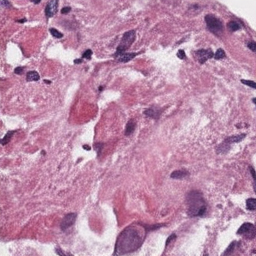

In [13]:
# %% — Cellule 9 : génération PixCell (UNI pos/neg, CFG propre)
from PIL import Image
import numpy as np
import torch

@torch.inference_mode()
def synth_from_pils(pils, guidance_scale=1.5, seed=123, num_images_per_prompt=1):
    """
    pils : liste de PIL RGB (longueur = B)
    - Embeddings UNI2-h au format (B, 1, 1536)
    - Si guidance_scale > 1 → negative_uni_embeds requis (helper officiel)
    - Pas de kwargs resolution/aspect_ratio avec PixCell
    """
    # 1) Embeddings UNI → (B, 1, 1536)
    pos = uni_embeds_for_pixcell(pils)  # ta cellule 4 modifiée

    # (Option) adapter gelé
    if "adapter" in globals() and adapter is not None:
        with torch.no_grad():
            pos = adapter(pos)

    # Harmoniser dtype/device (au cas où)
    pos = pos.to(device=next(pipe.transformer.parameters()).device,
                 dtype=next(pipe.transformer.parameters()).dtype)

    B = pos.shape[0]

    # 2) Négatif si CFG > 1
    neg = None
    if guidance_scale is not None and float(guidance_scale) > 1.0:
        neg = pipe.get_unconditional_embedding(B)  # (B, 1, 1536)
        if neg.ndim == 2:
            neg = neg.unsqueeze(1)
        neg = neg.to(device=pos.device, dtype=pos.dtype)

    # 3) Génération
    g = torch.Generator(device=pos.device).manual_seed(int(seed))

    with torch.amp.autocast("cuda", enabled=(pipe.transformer.dtype == torch.float16)):
        out = pipe(
            uni_embeds=pos,
            negative_uni_embeds=neg,
            guidance_scale=float(guidance_scale),
            num_images_per_prompt=int(num_images_per_prompt),
            generator=g,
        )

    return out.images  # liste de PIL


# --- Smoke test (remplace par une vraie tuile si tu veux) ---
test_img = Image.fromarray(np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8))
imgs = synth_from_pils([test_img], guidance_scale=1.5, seed=123, num_images_per_prompt=1)
display(imgs[0])


### Test sur une image du dataset

In [14]:
# Helper simple si le TIFF n'est pas exactement 256x256
from PIL import Image
def load_ref_image_any(path, target_hw=(256, 256)):
    img = Image.open(path)
    if getattr(img, "n_frames", 1) > 1:
        img.seek(0)
    if img.mode not in ("RGB",):
        img = img.convert("RGB")
    if target_hw and img.size != (target_hw[1], target_hw[0]):
        img = img.resize((target_hw[1], target_hw[0]), Image.BICUBIC)
    return img

  0%|          | 0/20 [00:00<?, ?it/s]

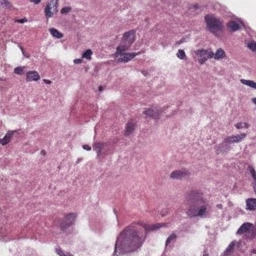

In [15]:
# Charge/resize le TIFF si besoin
img = load_ref_image_any("/workspace/data/NCT-CRC-HE-100K/TUM/TUM-AAHFEMQY.tif", target_hw=(256,256))
imgs = synth_from_pils([img], guidance_scale=1.5, seed=123, num_images_per_prompt=1)
display(imgs[0])

## 💾 Cell 13 — Sauvegarde / rechargement des LoRA

In [16]:
# %% — Sauver / Recharger les LoRA (patch custom v3)
import os, torch

def save_lora_params(transformer, path):
    state = {}
    for name, mod in transformer.named_modules():
        if hasattr(mod, "lora_A") and hasattr(mod, "lora_B") and hasattr(mod, "lora_scaling"):
            state[f"{name}.lora_A"] = mod.lora_A.detach().cpu()
            state[f"{name}.lora_B"] = mod.lora_B.detach().cpu()
            state[f"{name}.lora_scaling"] = mod.lora_scaling.detach().cpu()
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state, path)
    print(f"[LoRA] Sauvegardé → {path}  ({len(state)} tensors)")

def load_lora_params(transformer, path, strict=True, map_location="cpu"):
    state = torch.load(path, map_location=map_location)
    missing = []
    for key, tensor in state.items():
        *mod_path, attr = key.split(".")
        mod = transformer.get_submodule(".".join(mod_path))
        if not hasattr(mod, attr):
            if strict:
                missing.append(key)
        else:
            getattr(mod, attr).data.copy_(tensor.to(getattr(mod, attr).device, getattr(mod, attr).dtype))
    if missing:
        raise RuntimeError(f"Tensors LoRA manquants (strict=True) : {missing[:6]}{'...' if len(missing)>6 else ''}")
    print(f"[LoRA] Rechargé ← {path}")

### 📁 Arborescence projet (commune à tous les notebooks)

In [ ]:
from pathlib import Path
import os

# --- Emplacement du projet quand on lance depuis notebooks/ ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
print("PROJECT_ROOT =", PROJECT_ROOT)

# Dossiers globaux du projet
MODELS_DIR      = PROJECT_ROOT / "models"
ARTIFACTS_DIR   = PROJECT_ROOT / "artifacts"
SAMPLES_DIR     = PROJECT_ROOT / "samples"     / "08_uni2h_adapter_lora"
OUTPUTS_DIR     = PROJECT_ROOT / "outputs"     / "08_uni2h_adapter_lora"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "08_uni2h_adapter_lora"
RUNS_DIR        = PROJECT_ROOT / "runs"        / "08_uni2h_adapter_lora"

for d in [MODELS_DIR, ARTIFACTS_DIR, SAMPLES_DIR, OUTPUTS_DIR, CHECKPOINTS_DIR, RUNS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Exemple:
save_lora_params(pipe.transformer, CHECKPOINTS_DIR / "pixcell_lora_v0.pt")
# load_lora_params(pipe.transformer, "./lora_checkpoints/pixcell_lora_v0.pt")

PROJECT_ROOT = /workspace
[LoRA] Sauvegardé → /workspace/checkpoints/08_uni2h_adapter_lora/pixcell_lora_v0.pt  (252 tensors)


## 🧾 Cell 10 — Test avec histo_dataset
Base (identique à 07_Diffusion_Model

In [ ]:
# =========================================================
# 🔧 Imports projet (p9dg + metrics) — chemin propre
# =========================================================
import sys, os
from pathlib import Path

# --- Emplacement du projet quand on lance depuis notebooks/ ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()

# 👉 On ajoute UNIQUEMENT la racine du projet
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"PROJECT_ROOT = {PROJECT_ROOT}")

# Imports package-qualifiés
from p9dg.histo_dataset import HistoDataset
print("✅ Import HistoDataset depuis p9dg")

from metrics.cnn_eval import run_eval_split
print("✅ Import cnn_eval depuis metrics")

PROJECT_ROOT = /workspace
✅ Import HistoDataset depuis p9dg
✅ Import cnn_eval depuis metrics


## 🔌 HistoDataset + deux DataLoaders (train & viz)

In [19]:
# === HistoDataset + DataLoaders (train & viz) ===
import os, sys, numpy as np, torch
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as T

# 0) Import robuste (package p9dg OU fichier local histo_dataset.py)
try:
    from p9dg.histo_dataset import HistoDataset, BalancedRoundRobinSampler
except Exception:
    sys.path.append(os.getcwd())
    try:
        from histo_dataset import HistoDataset, BalancedRoundRobinSampler
    except Exception as e:
        raise ImportError("Impossible d'importer HistoDataset. "
                          "Assure-toi que p9dg/histo_dataset.py ou histo_dataset.py est dispo.") from e

# 1) Paramètres (adapte ROOT_DATA si besoin)
ROOT_DATA   = globals().get("ROOT_DATA", "/workspace/data")
SPLIT       = globals().get("SPLIT", "train")
IMG_SIZE    = globals().get("IMG_SIZE", 256)
BATCH_SIZE  = globals().get("BATCH_SIZE", 4)
NUM_WORKERS = 0 # globals().get("NUM_WORKERS", max(2, (os.cpu_count() or 4)//2))
SAMPLES_PER_CLASS = globals().get("SAMPLES_PER_CLASS", 500)  # petit tirage/epoch pour test

assert os.path.isdir(ROOT_DATA), f"ROOT_DATA introuvable: {ROOT_DATA}"

# 2) Dataset équilibré (rapide, sans filtres) — renvoie x∈[0,1]
ds = HistoDataset(
    root_data=ROOT_DATA,
    split=SPLIT,
    output_size=IMG_SIZE,
    pixel_range="0_1",             # on lit en [0,1]
    balance_per_class=True,
    samples_per_class_per_epoch=SAMPLES_PER_CLASS, #None
    apply_quality_filter=True,
    vahadane_enable=False,
    vahadane_device="cuda",
#    classes=["TUM"],
    return_labels=True,
)
sampler = BalancedRoundRobinSampler(ds, seed=42)

# 3) Collate pour visualisation: renvoie (pils, xs[-1,1], ys, paths)
def _collate_vis(batch):
    pils, xs, ys, paths = [], [], [], []
    for x, y, p in batch:
        # x: Tensor [3,H,W] en [0,1] → PIL 256x256
        arr = (x.permute(1,2,0).numpy()*255.0).astype(np.uint8)
        pils.append(Image.fromarray(arr).convert("RGB"))
        # pour le modèle: on passe en [-1,1]
        xs.append(x*2.0 - 1.0)
        ys.append(y); paths.append(p)
    return pils, torch.stack(xs,0), torch.tensor(ys), paths

# Collate train : ne renvoie QUE les images en [-1,1] (pratique pour la boucle)
def _collate_train(batch):
    imgs = [(x*2.0 - 1.0) for (x,_,_) in batch]
    return torch.stack(imgs, 0)

# 4) DataLoaders
dl_vis = DataLoader(
    ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0),
    prefetch_factor=(2 if NUM_WORKERS>0 else None), collate_fn=_collate_vis
)

train_loader = DataLoader(
    ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=(NUM_WORKERS>0),
    prefetch_factor=(2 if NUM_WORKERS>0 else None), collate_fn=_collate_train
)

# 5) Sanity du flux de données
pils, xs, ys, paths = next(iter(dl_vis))
mn, mx = float(xs.min()), float(xs.max())
print(f"✓ HistoDataset: {len(ds)} échantillons | split={SPLIT} | classes≈{getattr(ds,'num_classes','?')}")
print(f"✓ dl_vis batch: PILs={len(pils)} | xs={tuple(xs.shape)} ~ range [{mn:.2f},{mx:.2f}] | ys={tuple(ys.shape)}")
xb = next(iter(train_loader))
mn2, mx2 = float(xb.min()), float(xb.max())
print(f"✓ train_loader batch: {tuple(xb.shape)} ~ range [{mn2:.2f},{mx2:.2f}] ([-1,1] attendu)")

# 6) Import et configuration des mappings de classes
import sys
from pathlib import Path
sys.path.append(str(Path.cwd()))
from p9dg.utils.class_mappings import class_labels, make_idx_mappings

# Créer les mappings depuis le dataset
if hasattr(ds, 'class_to_idx'):
    idx_to_name, idx_to_color, name_to_color = make_idx_mappings(ds.class_to_idx)
    print(f"✓ Mappings de classes créés: {len(idx_to_name)} classes")
    print(f"  Exemple: idx 0 → {idx_to_name.get(0, '?')}")
else:
    # Fallback: créer un mapping basique si class_to_idx n'existe pas
    print("⚠️ class_to_idx non trouvé dans le dataset, création d'un mapping basique")
    idx_to_name = {i: f"Class_{i}" for i in range(9)}
    idx_to_color = {}
    name_to_color = {}


✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (500 images / classe).
✓ HistoDataset: 4500 échantillons | split=train | classes≈?
✓ dl_vis batch: PILs=4 | xs=(4, 3, 256, 256) ~ range [-1.00,1.00] | ys=(4,)
✓ train_loader batch: (4, 3, 256, 256) ~ range [-1.00,1.00] ([-1,1] attendu)
✓ Mappings de classes créés: 9 classes
  Exemple: idx 0 → Tissu adipeux


📊 Batch de 4 images pour sanity check:
  Image 0: classe=Tissu adipeux (idx=0)
  Image 1: classe=Arrière-plan (fond sans tissu) (idx=1)
  Image 2: classe=Débris cellulaires / nécrose (idx=2)
  Image 3: classe=Lymphocytes (infiltrat immunitaire) (idx=3)

🔍 Extraction des embeddings UNI pour chaque image:
  Image 0 (Tissu adipeux): embedding shape=(1, 1, 1536), norm=1.0000
  Image 1 (Arrière-plan (fond sans tissu)): embedding shape=(1, 1, 1536), norm=1.0000
  Image 2 (Débris cellulaires / nécrose): embedding shape=(1, 1, 1536), norm=1.0000
  Image 3 (Lymphocytes (infiltrat immunitaire)): embedding shape=(1, 1, 1536), norm=1.0000

🔍 Vérification de la diversité des embeddings:
  Similarités cosinus entre embeddings:
    Image 0 (Tissu adipeux) vs Image 1 (Arrière-plan (fond sans tissu)): 0.1765
    Image 0 (Tissu adipeux) vs Image 2 (Débris cellulaires / nécrose): 0.1549
    Image 0 (Tissu adipeux) vs Image 3 (Lymphocytes (infiltrat immunitaire)): 0.1157
    Image 1 (Arrière-plan (fond sa

  0%|          | 0/12 [00:00<?, ?it/s]

  ✓ Image 0 (Tissu adipeux): générée avec ctx, seed=123


  0%|          | 0/12 [00:00<?, ?it/s]

  ✓ Image 1 (Arrière-plan (fond sans tissu)): générée avec ctx, seed=124


  0%|          | 0/12 [00:00<?, ?it/s]

  ✓ Image 2 (Débris cellulaires / nécrose): générée avec ctx, seed=125


  0%|          | 0/12 [00:00<?, ?it/s]

  ✓ Image 3 (Lymphocytes (infiltrat immunitaire)): générée avec ctx, seed=126


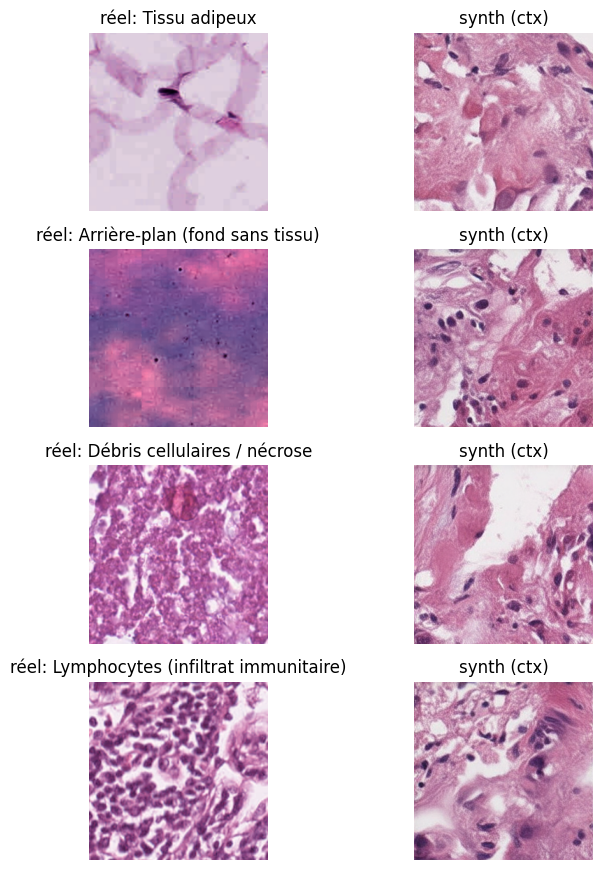

✅ Sanity-check génération — n=4, mode='ctx', device=cuda, DTYPE=torch.float16, MODEL_DTYPE=torch.float16
   Classes dans le batch: ['Tissu adipeux', 'Arrière-plan (fond sans tissu)', 'Débris cellulaires / nécrose', 'Lymphocytes (infiltrat immunitaire)']
   Synth stats ~ mean=0.667, std=0.168  (si mean≈0 & std≈0 → sortie trop sombre/noire)


In [20]:
# %% 🔍 Sanity-check génération (utilise dl_vis & train_loader existants)
import torch, numpy as np, matplotlib.pyplot as plt
from torchvision import transforms

# ── Contexte déjà créé plus haut ──
device = globals().get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
DTYPE  = globals().get("DTYPE", torch.float16)
assert 'dl_vis' in globals(), "dl_vis introuvable : exécute d'abord la cellule HistoDataset + DataLoaders."
assert 'adapter' in globals(), "adapter introuvable : exécute d'abord la cellule Adapter."

# Pipeline + backbone
PIPE = None
for cand in ("pipe256", "pipe", "pipeline", "pixcell_pipe"):
    if cand in globals(): PIPE = globals()[cand]; break
assert PIPE is not None, "Pipeline PixCell introuvable (pipe/pipe256/pipeline)."

BACKBONE = getattr(PIPE, "transformer", None) or getattr(PIPE, "unet", None)
assert BACKBONE is not None, "Backbone introuvable sur la pipeline (ni .transformer ni .unet)."
MODEL_DTYPE = next(BACKBONE.parameters()).dtype

# Helpers UNI (au moins l'un)
uni_embeds_for_pixcell = globals().get("uni_embeds_for_pixcell", None)
uni_pos_neg_from_pils  = globals().get("uni_pos_neg_from_pils", None)
assert (uni_embeds_for_pixcell is not None) or (uni_pos_neg_from_pils is not None), \
       "Définis uni_embeds_for_pixcell(pils) ou uni_pos_neg_from_pils(pils) plus haut."

# Petits helpers locaux (pas de redéfinition de dataloader)
@torch.no_grad()
def _ensure_b1x1536(x):
    if x.dim() == 2:
        x = x.unsqueeze(1)
    assert x.dim()==3 and x.size(1)==1 and x.size(2)==1536, f"Bad shape {tuple(x.shape)}"
    return x

@torch.no_grad()
def _encode_uni_to_ctx(pos_uni, neg_uni=None):
    pos_uni = _ensure_b1x1536(pos_uni).to(device, dtype=DTYPE)
    neg_uni = (_ensure_b1x1536(neg_uni).to(device, dtype=DTYPE)
               if neg_uni is not None else torch.zeros_like(pos_uni))
    pos_ctx = adapter(pos_uni)  # Adapter: FP32 interne + recast vers dtype modèle
    neg_ctx = adapter(neg_uni)
    return pos_ctx, neg_ctx

# Prélève un batch visuel (PILs + tensors en [-1,1] déjà via ta collate)
pils, xs, ys, paths = next(iter(dl_vis))  # xs: [B,3,256,256] en [-1,1]
B = len(pils)

# Afficher les classes des images réelles pour vérification
idx_to_name_global = globals().get("idx_to_name", {})
if not idx_to_name_global and "ds" in globals() and hasattr(ds, 'class_to_idx'):
    from p9dg.utils.class_mappings import make_idx_mappings
    idx_to_name_global, _, _ = make_idx_mappings(ds.class_to_idx)

print(f"📊 Batch de {B} images pour sanity check:")
for i in range(B):
    class_idx = int(ys[i].item()) if hasattr(ys[i], 'item') else int(ys[i])
    class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
    print(f"  Image {i}: classe={class_name} (idx={class_idx})")

# UNI pos/neg - IMPORTANT: extraire les embeddings individuellement pour chaque image
# pour s'assurer que chaque classe produit un embedding unique
print(f"\n🔍 Extraction des embeddings UNI pour chaque image:")
pos_uni_list = []
neg_uni_list = []

with torch.inference_mode():
    for i, pil in enumerate(pils):
        # Extraire l'embedding UNI pour chaque image individuellement
        if uni_pos_neg_from_pils is not None:
            pos_uni_i, neg_uni_i = uni_pos_neg_from_pils([pil])  # [1,1,1536] chacun
        else:
            pos_uni_i = uni_embeds_for_pixcell([pil])  # [1,1,1536]
            neg_uni_i = _pipe.get_unconditional_embedding(1)  # [1,1,1536]
            if neg_uni_i.ndim == 2:
                neg_uni_i = neg_uni_i.unsqueeze(1)
        # Garder la forme [1, 1, 1536] pour pouvoir concaténer en batch
        if pos_uni_i.ndim == 2:
            pos_uni_i = pos_uni_i.unsqueeze(1)  # [1, 1, 1536]
        if neg_uni_i.ndim == 2:
            neg_uni_i = neg_uni_i.unsqueeze(1)  # [1, 1, 1536]
        pos_uni_list.append(pos_uni_i)  # Garde [1, 1, 1536]
        neg_uni_list.append(neg_uni_i)  # Garde [1, 1, 1536]
        
        class_idx = int(ys[i].item()) if hasattr(ys[i], 'item') else int(ys[i])
        class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
        print(f"  Image {i} ({class_name}): embedding shape={tuple(pos_uni_i.shape)}, norm={pos_uni_i.norm().item():.4f}")

# Vérifier que les embeddings sont différents entre les images
print(f"\n🔍 Vérification de la diversité des embeddings:")
if len(pos_uni_list) > 1:
    pos_uni_stack = torch.cat(pos_uni_list, dim=0)  # [B, 1, 1536]
    # Calculer les similarités cosinus entre embeddings
    pos_uni_flat = pos_uni_stack.squeeze(1)  # [B, 1536]
    similarities = torch.mm(pos_uni_flat, pos_uni_flat.t())  # [B, B]
    print(f"  Similarités cosinus entre embeddings:")
    for i in range(B):
        for j in range(i+1, B):
            sim = similarities[i, j].item()
            class_i = idx_to_name_global.get(int(ys[i].item() if hasattr(ys[i], 'item') else ys[i]), f"Class_{ys[i]}")
            class_j = idx_to_name_global.get(int(ys[j].item() if hasattr(ys[j], 'item') else ys[j]), f"Class_{ys[j]}")
            print(f"    Image {i} ({class_i}) vs Image {j} ({class_j}): {sim:.4f}")
    
    # Vérifier qu'il y a des différences significatives
    max_sim = similarities[~torch.eye(B, dtype=bool, device=similarities.device)].max().item()
    min_sim = similarities[~torch.eye(B, dtype=bool, device=similarities.device)].min().item()
    print(f"  Similarité max (hors diagonale): {max_sim:.4f}")
    print(f"  Similarité min (hors diagonale): {min_sim:.4f}")
    if max_sim > 0.99:
        print(f"  ⚠️ ATTENTION: Similarité très élevée entre embeddings, les images pourraient être trop similaires!")

# Convertir en batch pour l'adapter (concaténer au lieu de stack pour éviter les dimensions en trop)
pos_uni_batch = torch.cat(pos_uni_list, dim=0)  # [B, 1, 1536]
neg_uni_batch = torch.cat(neg_uni_list, dim=0)  # [B, 1, 1536]

# Appliquer l'adapter (mais on va générer image par image)
pos_ctx, neg_ctx = _encode_uni_to_ctx(pos_uni_batch, neg_uni_batch)

print(f"\n🎨 Génération individuelle avec seed unique par image:")
# Génération: image par image avec seed différent pour chaque image

def _to_pils(out):
    if isinstance(out, list): return out
    imgs = getattr(out, "images", None)
    return imgs if imgs is not None else out

# Génération image par image avec seed unique pour garantir la diversité
gen = []
base_seed = 123

for i in range(B):
    class_idx = int(ys[i].item()) if hasattr(ys[i], 'item') else int(ys[i])
    class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
    
    # Seed unique pour chaque image (basé sur l'index + base_seed)
    g = torch.Generator(device=device).manual_seed(base_seed + i)
    
    # Extraire les embeddings adaptés pour cette image seule
    pos_ctx_i = pos_ctx[i:i+1]  # [1, 1, 1536] ou [1, seq_len, cross_attn_dim]
    neg_ctx_i = neg_ctx[i:i+1]
    
    mode_used_i = None
    try:
        with torch.autocast(device_type="cuda", dtype=DTYPE):
            out = PIPE(
                uni_embeds=pos_ctx_i, negative_uni_embeds=neg_ctx_i,
                guidance_scale=1.5, num_inference_steps=12,
                num_images_per_prompt=1, generator=g,
                height=xs.shape[-1], width=xs.shape[-1],
                output_type="pil",
            )
        gen_i = _to_pils(out)
        if isinstance(gen_i, list):
            gen.append(gen_i[0])
        else:
            gen.append(gen_i)
        mode_used_i = "ctx"
        print(f"  ✓ Image {i} ({class_name}): générée avec ctx, seed={base_seed + i}")
    except Exception as e_ctx:
        # Fallback: utiliser les embeddings UNI bruts
        pos_uni_i = pos_uni_batch[i:i+1]  # [1, 1, 1536]
        neg_uni_i = neg_uni_batch[i:i+1]
        with torch.inference_mode():
            pu = _ensure_b1x1536(pos_uni_i).to(MODEL_DTYPE).to(device)
            nu = _ensure_b1x1536(neg_uni_i).to(MODEL_DTYPE).to(device)
        with torch.autocast(device_type="cuda", dtype=DTYPE):
            out = PIPE(
                uni_embeds=pu, negative_uni_embeds=nu,
                guidance_scale=1.5, num_inference_steps=12,
                num_images_per_prompt=1, generator=g,
                height=xs.shape[-1], width=xs.shape[-1],
                output_type="pil",
            )
        gen_i = _to_pils(out)
        if isinstance(gen_i, list):
            gen.append(gen_i[0])
        else:
            gen.append(gen_i)
        mode_used_i = "uni"
        print(f"  ✓ Image {i} ({class_name}): générée avec uni brut (fallback), seed={base_seed + i}")

mode_used = mode_used_i if mode_used_i else "ctx"

# Affichage pairé + petites stats (détecte les sorties "noires")
# Récupérer les mappings de classes si disponibles
idx_to_name_global = globals().get("idx_to_name", {})
if not idx_to_name_global and "ds" in globals() and hasattr(ds, 'class_to_idx'):
    from p9dg.utils.class_mappings import make_idx_mappings
    idx_to_name_global, _, _ = make_idx_mappings(ds.class_to_idx)

n = min(B, len(gen))
means, stds = [], []
plt.figure(figsize=(8, 2.2*n))
for i in range(n):
    # Titre avec classe pour l'image réelle
    class_idx = int(ys[i].item()) if i < len(ys) else -1
    class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}") if class_idx >= 0 else "Unknown"
    real_title = f"réel: {class_name}"
    
    ax = plt.subplot(n, 2, 2*i+1); ax.imshow(pils[i]); ax.set_title(real_title);  ax.axis("off")
    ax = plt.subplot(n, 2, 2*i+2); ax.imshow(gen[i]);  ax.set_title(f"synth ({mode_used})"); ax.axis("off")
    arr = np.asarray(gen[i], dtype=np.float32)/255.0
    means.append(float(arr.mean())); stds.append(float(arr.std()))
plt.tight_layout(); plt.show()

print(f"✅ Sanity-check génération — n={n}, mode='{mode_used}', device={device}, DTYPE={DTYPE}, MODEL_DTYPE={MODEL_DTYPE}")
print(f"   Classes dans le batch: {[idx_to_name_global.get(int(y.item()), f'Class_{int(y.item())}') for y in ys[:n]]}")
print(f"   Synth stats ~ mean={np.mean(means):.3f}, std={np.mean(stds):.3f}  "
      f"(si mean≈0 & std≈0 → sortie trop sombre/noire)")


## 🧪 Cell 11 — Dégeler l’adapter (affine 1536)

## 🎯 Cell 12 — (Ré)injection LoRA sur le transformer (idempotent)

## ⚙️ Optimiseur + scheduler (LoRA & adapter)

## 🧩 Preparation de Adapter (FP32 + patchs + helpers)

## 🛠️ Setup robuste (grads, opti, scheduler, sécurité)

## 🔁 Boucle d’entraînement (ε-pred, CFG, contrôles)

## ✨ Cellule 4 — Mini-génération (sanity check)

## 📐 Batch et sauvegarde finale

In [21]:
# === Toggles mémoire : checkpointing, attn slicing/xformers, VAE tiling ===
try:
    BACKBONE.enable_gradient_checkpointing()
    print("✓ Gradient checkpointing activé")
except Exception as e:
    print("↷ Checkpointing indisponible sur ce backbone :", type(e).__name__)

# xFormers / FlashAttention / slicing
ok_attn = False
try:
    BACKBONE.enable_xformers_memory_efficient_attention()
    print("✓ xFormers attention"); ok_attn = True
except Exception:
    try:
        from diffusers.models.attention_processor import AttnProcessor2_0
        BACKBONE.set_attn_processor(AttnProcessor2_0())
        print("✓ AttnProcessor2_0"); ok_attn = True
    except Exception:
        try:
            BACKBONE.enable_attention_slicing("max")
            print("✓ Attention slicing (fallback)"); ok_attn = True
        except Exception as e:
            print("↷ Pas de backend attn optimisé :", type(e).__name__)

# VAE encode/decode par tuiles (gros gain mémoire)
try:
    VAE.enable_tiling(); VAE.enable_slicing()
    print("✓ VAE tiling + slicing")
except Exception as e:
    print("↷ VAE tiling/slicing non supporté :", type(e).__name__)

# Option : réduis la résolution si tu es short
IMG_SIZE = int(globals().get('IMG_SIZE', 256))
# IMG_SIZE = 192  # ← décommente si besoin d’un cran de marge


✓ Gradient checkpointing activé
✓ AttnProcessor2_0
↷ VAE tiling/slicing non supporté : NameError


In [22]:
# %% 🧹 OOM cleanup — ferme figures, libère tenseurs, retire hooks, vide caches CUDA
import gc, sys
import torch
import matplotlib
import types

def _mb(x): 
    return f"{x/1024/1024:.1f} MB"

# 1) Fermer toutes les figures Matplotlib
try:
    import matplotlib.pyplot as plt
    plt.close('all')
    print("✔️ Figures Matplotlib fermées.")
except Exception as e:
    print("ℹ️ plt.close('all') ignoré:", e)

# 2) Retirer le hook 'noise-only' si présent
try:
    _pipe = globals().get("pipe", None) or globals().get("pipe256", None)
    if _pipe is not None and getattr(_pipe.transformer, "_noise_only_handle", None) is not None:
        _pipe.transformer._noise_only_handle.remove()
        _pipe.transformer._noise_only_handle = None
        print("✔️ Hook 'noise-only' retiré.")
except Exception as e:
    print("ℹ️ Retrait hook ignoré:", e)

# 3) Supprimer variables temporaires fréquentes
to_del = [
    "out","images","pils","pils_show","x01","latents","noise","noisy","pred","target",
    "pos_uni","neg_uni","pos_enc","neg_enc","g","batch","dl_iter"
]
freed = 0
for name in to_del:
    if name in globals():
        try:
            obj = globals()[name]
            del globals()[name]
            freed += 1
        except Exception:
            pass
print(f"✔️ Variables temporaires supprimées: {freed}")

# 4) Forcer le GC Python
collected = gc.collect()
print(f"✔️ GC collecté: {collected} objets")

# 5) Vidage des caches CUDA
if torch.cuda.is_available():
    try:
        torch.cuda.synchronize()
    except Exception:
        pass
    try:
        before_alloc = torch.cuda.memory_allocated()
        before_resrv = torch.cuda.memory_reserved()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.reset_peak_memory_stats()
        after_alloc  = torch.cuda.memory_allocated()
        after_resrv  = torch.cuda.memory_reserved()
        print(f"✔️ CUDA cache vidé. Alloc {_mb(before_alloc)} → {_mb(after_alloc)} | Reserved {_mb(before_resrv)} → {_mb(after_resrv)}")
    except Exception as e:
        print("ℹ️ Cleanup CUDA ignoré:", e)
else:
    print("ℹ️ CUDA non disponible.")

print("✅ Ménage fini — si besoin, relance la génération avec un batch/steps plus petits (ex: N_SHOW=2, GEN_STEPS=12).")


✔️ Figures Matplotlib fermées.
✔️ Variables temporaires supprimées: 3
✔️ GC collecté: 12 objets
✔️ CUDA cache vidé. Alloc 3973.8 MB → 3973.8 MB | Reserved 4464.0 MB → 4190.0 MB
✅ Ménage fini — si besoin, relance la génération avec un batch/steps plus petits (ex: N_SHOW=2, GEN_STEPS=12).


## 🎯 Cellule A — Setup trainables (dégeler Adapter + LoRA, cast FP32)


In [23]:
# %% 🔓 Setup trainables : dégeler LoRA uniquement, geler backbone et Adapter, cast FP32 sur trainables
import torch
import torch.nn as nn

# 1) Récupérer les objets existants
assert "adapter" in globals() and adapter is not None, "Adapter introuvable"
assert "pipe" in globals() or "pipe256" in globals(), "Pipeline introuvable"
_pipe = globals().get("pipe", None) or globals().get("pipe256", None)

# Définir BACKBONE et MODEL_DTYPE globalement
BACKBONE = getattr(_pipe, "transformer", None) or getattr(_pipe, "unet", None)
assert BACKBONE is not None, "Backbone introuvable (ni .transformer ni .unet)"
MODEL_DTYPE = next(BACKBONE.parameters()).dtype
VAE = getattr(_pipe, "vae", None)

print(f"✓ BACKBONE: {type(BACKBONE).__name__}, dtype={MODEL_DTYPE}")
print(f"✓ VAE: {type(VAE).__name__ if VAE else 'None'}")

# 2) Geler TOUT le backbone (sauf LoRA qui seront gérés séparément)
for name, param in BACKBONE.named_parameters():
    if "lora_" not in name.lower():  # Ne pas geler les LoRA
        param.requires_grad = False

# Geler VAE si présent
if VAE is not None:
    for param in VAE.parameters():
        param.requires_grad = False

# 3) DÉGELER Adapter (ENTRAÎNABLE avec LR faible pour stabilité)
# L'adapter joue un rôle crucial dans l'adaptation des embeddings UNI2-h
# On le rend entraînable avec un learning rate plus faible que les LoRA pour une adaptation fine
for param in adapter.parameters():
    param.requires_grad = True
print(f"✓ Adapter DÉGELÉ (entraînable): {sum(p.numel() for p in adapter.parameters()):,} params")

# 4) S'assurer que les LoRA sont entraînables (ré-injection si besoin)
if "lora_params" not in globals() or len(lora_params) == 0:
    RANK = globals().get("RANK", 16)  # Par défaut augmenté à 16 (au lieu de 8)
    ALPHA = globals().get("ALPHA", 32)  # Par défaut augmenté à 32 (au lieu de 16)
    lora_params = inject_lora_pixcell_transformer_v3(_pipe, rank=RANK, alpha=ALPHA)
    print(f"✓ LoRA ré-injectées: {len(lora_params)} tensors")
else:
    # Vérifier que les LoRA sont entraînables
    for p in lora_params:
        p.requires_grad = True
    print(f"✓ LoRA déjà présentes: {len(lora_params)} tensors")

# 5) Helper: cast les trainables en FP32 (LoRA + Adapter)
def cast_trainables_to_fp32(lora_params, adapter):
    """Force FP32 sur tous les paramètres trainables (LoRA + Adapter)"""
    # LoRA
    for param in lora_params:
        if param.requires_grad:
            param.data = param.data.float()
    # Adapter
    for param in adapter.parameters():
        if param.requires_grad:
            param.data = param.data.float()
    print("✓ Trainables (LoRA + Adapter) castés en FP32")

cast_trainables_to_fp32(lora_params, adapter)

# 6) Vérification finale
def print_trainables():
    """Affiche tous les paramètres trainables"""
    trainable = []
    # LoRA
    lora_total = 0
    for i, param in enumerate(lora_params):
        if param.requires_grad:
            lora_total += param.numel()
            trainable.append((f"lora_{i}", param.numel()))
    # Adapter
    adapter_trainable = [p for p in adapter.parameters() if p.requires_grad]
    adapter_total = sum(p.numel() for p in adapter_trainable) if len(adapter_trainable) > 0 else 0
    if adapter_total > 0:
        trainable.append(("adapter", adapter_total))
    
    total = sum(n for _, n in trainable)
    print(f"✓ Paramètres trainables (LoRA + Adapter): {len(trainable)} groupes, {total:,} params")
    if adapter_total > 0:
        print(f"  - LoRA: {lora_total:,} params")
        print(f"  - Adapter: {adapter_total:,} params")
    return trainable

trainable_list = print_trainables()


✓ BACKBONE: PixCellTransformer2DModel, dtype=torch.float16
✓ VAE: AutoencoderKL
✓ Adapter DÉGELÉ (entraînable): 4,724,736 params
✓ LoRA déjà présentes: 168 tensors
✓ Trainables (LoRA + Adapter) castés en FP32
✓ Paramètres trainables (LoRA + Adapter): 169 groupes, 7,821,312 params
  - LoRA: 3,096,576 params
  - Adapter: 4,724,736 params


## ⚙️ Cellule B — Optimizer + Scheduler (AdamW, 2 groupes, warmup+cosine)


In [24]:
# %% ⚙️ Optimizer + Scheduler (AdamW, LoRA uniquement, warmup+cosine)
import torch
from torch.optim import AdamW
import math

# 1) Récupérer les paramètres trainables (LoRA + Adapter)
lora_params_trainable = [p for p in lora_params if p.requires_grad]
adapter_params_trainable = [p for p in adapter.parameters() if p.requires_grad]

assert len(lora_params_trainable) > 0, "Aucun paramètre LoRA trainable"
assert len(adapter_params_trainable) > 0, "⚠️ L'adapter devrait être entraînable !"

# 2) Créer optimizer avec deux groupes (LoRA + Adapter) - LR réduits pour stabilité
# Option 1: Réduire le LR pour stabiliser l'entraînement
LR_LORA = 5e-6     # Réduit de 2e-5 à 5e-6 (×4) pour éviter la divergence
LR_ADAPTER = 2.5e-6  # LR encore plus faible pour l'adapter (2× plus faible que LoRA) - adaptation fine
WEIGHT_DECAY = 0.01
BETAS = (0.9, 0.999)
EPS = 1e-8

optimizer = AdamW(
    [
        {"params": lora_params_trainable, "lr": LR_LORA, "weight_decay": WEIGHT_DECAY},
        {"params": adapter_params_trainable, "lr": LR_ADAPTER, "weight_decay": WEIGHT_DECAY},
    ],
    betas=BETAS,
    eps=EPS,
)

print(f"✓ Optimizer créé (2 groupes pour stabilité):")
print(f"  - LoRA: {len(lora_params_trainable)} params, LR={LR_LORA} (réduit pour stabilité)")
print(f"  - Adapter: {len(adapter_params_trainable)} params, LR={LR_ADAPTER} (2× plus faible pour adaptation fine)")

# 3) Scheduler: warmup + cosine (warmup augmenté pour stabilité)
NUM_TRAIN_STEPS = 500  # Paramètres originaux (retour à la configuration de base)
WARMUP_STEPS = max(300, int(0.1 * NUM_TRAIN_STEPS))  # Augmenté à 300 (au lieu de 200) pour un démarrage plus progressif

try:
    from diffusers.optimization import get_cosine_schedule_with_warmup
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=NUM_TRAIN_STEPS,
    )
    print(f"✓ Scheduler (diffusers): warmup={WARMUP_STEPS}, total={NUM_TRAIN_STEPS}")
except ImportError:
    # Fallback: scheduler cosine maison
    class CosineScheduleWithWarmup:
        def __init__(self, optimizer, num_warmup_steps, num_training_steps):
            self.optimizer = optimizer
            self.num_warmup_steps = num_warmup_steps
            self.num_training_steps = num_training_steps
            self.base_lrs = [group['lr'] for group in optimizer.param_groups]
            self.last_epoch = -1
        
        def step(self, epoch=None):
            if epoch is None:
                epoch = self.last_epoch + 1
            self.last_epoch = epoch
            
            if epoch < self.num_warmup_steps:
                # Warmup: linéaire de 0 à base_lr
                lr_scale = epoch / self.num_warmup_steps
            else:
                # Cosine decay
                progress = (epoch - self.num_warmup_steps) / (self.num_training_steps - self.num_warmup_steps)
                lr_scale = 0.5 * (1 + math.cos(math.pi * progress))
            
            for param_group, base_lr in zip(self.optimizer.param_groups, self.base_lrs):
                param_group['lr'] = base_lr * lr_scale
        
        def get_last_lr(self):
            return [group['lr'] for group in self.optimizer.param_groups]
    
    scheduler = CosineScheduleWithWarmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=NUM_TRAIN_STEPS,
    )
    print(f"✓ Scheduler (maison): warmup={WARMUP_STEPS}, total={NUM_TRAIN_STEPS}")

# Test scheduler
scheduler.step(0)
print(f"✓ LR initiales: {scheduler.get_last_lr()}")


✓ Optimizer créé (2 groupes pour stabilité):
  - LoRA: 168 params, LR=5e-06 (réduit pour stabilité)
  - Adapter: 6 params, LR=2.5e-06 (2× plus faible pour adaptation fine)
✓ Scheduler (diffusers): warmup=300, total=500
✓ LR initiales: [0.0, 0.0]


## 🔌 Cellule C — encode_uni_to_ctx (robuste, FP32 → MODEL_DTYPE)


In [25]:
# %% 🔌 encode_uni_to_ctx (robuste, FP32 in → MODEL_DTYPE out, shapes corrigées)
import torch
import torch.nn.functional as F

# Récupérer cross_attention_dim du backbone
if hasattr(BACKBONE, "config") and hasattr(BACKBONE.config, "cross_attention_dim"):
    CROSS_ATTN_DIM = BACKBONE.config.cross_attention_dim
elif hasattr(BACKBONE, "config") and "cross_attention_dim" in BACKBONE.config:
    CROSS_ATTN_DIM = BACKBONE.config["cross_attention_dim"]
else:
    # Fallback: utiliser la dimension des embeddings UNI (1536) ou une valeur par défaut
    CROSS_ATTN_DIM = 1536
    print("⚠️ cross_attention_dim non trouvé, utilisation de 1536 par défaut")

# Longueur de séquence attendue (p.ex. 77 pour SD, 120 pour PixArt)
SEQ_LEN = 77  # Ajuste si nécessaire selon le backbone

print(f"✓ Config: cross_attn_dim={CROSS_ATTN_DIM}, seq_len={SEQ_LEN}, MODEL_DTYPE={MODEL_DTYPE}")

@torch.no_grad()
def encode_uni_to_ctx(pos_uni, neg_uni=None, desired_dtype=MODEL_DTYPE):
    """
    Encode UNI embeddings en contexte pour le backbone.
    
    Args:
        pos_uni: [B, 1, 1536] ou [B, 1536] - embeddings UNI positifs
        neg_uni: [B, 1, 1536] ou [B, 1536] ou None - embeddings UNI négatifs
        desired_dtype: dtype de sortie (MODEL_DTYPE)
    
    Returns:
        pos_ctx: [B, SEQ_LEN, CROSS_ATTN_DIM] en desired_dtype
        neg_ctx: [B, SEQ_LEN, CROSS_ATTN_DIM] en desired_dtype
    """
    # 1) Normaliser shapes: [B, 1, 1536] ou [B, 1536] → [B, 1, 1536]
    if pos_uni.ndim == 2:
        pos_uni = pos_uni.unsqueeze(1)
    assert pos_uni.ndim == 3 and pos_uni.size(1) == 1 and pos_uni.size(2) == 1536, \
        f"pos_uni shape attendu [B,1,1536], reçu {tuple(pos_uni.shape)}"
    
    B = pos_uni.size(0)
    
    # 2) Négatif: cloner pos_uni ou utiliser zero-embed si None
    if neg_uni is None:
        neg_uni = torch.zeros_like(pos_uni)
    else:
        if neg_uni.ndim == 2:
            neg_uni = neg_uni.unsqueeze(1)
        assert neg_uni.ndim == 3 and neg_uni.size(1) == 1 and neg_uni.size(2) == 1536, \
            f"neg_uni shape attendu [B,1,1536], reçu {tuple(neg_uni.shape)}"
    
    # 3) Adapter forward en FP32 (sans autocast)
    # Convertir l'adapter temporairement en FP32 pour éviter les conflits de types
    with torch.cuda.amp.autocast(enabled=False):
        # Cast entrées en FP32
        pos_uni_fp32 = pos_uni.float()
        neg_uni_fp32 = neg_uni.float()
        
        # Convertir l'adapter temporairement en FP32 si nécessaire
        adapter_original_dtype = next(adapter.parameters()).dtype
        adapter_was_fp16 = (adapter_original_dtype == torch.float16)
        
        if adapter_was_fp16:
            # Convertir temporairement l'adapter en FP32
            adapter_fp32 = adapter.float()
        else:
            adapter_fp32 = adapter
        
        # Forward Adapter (tous les params sont maintenant en FP32)
        pos_ctx_fp32 = adapter_fp32(pos_uni_fp32)  # [B, 1, 1536] ou [B, 1, CROSS_ATTN_DIM]
        neg_ctx_fp32 = adapter_fp32(neg_uni_fp32)
    
    # 4) Vérifier/adapter la dimension de sortie
    if pos_ctx_fp32.size(2) != CROSS_ATTN_DIM:
        # Si l'adapter produit 1536 mais on a besoin de CROSS_ATTN_DIM, projeter
        # Note: cette projection doit être trainable si on veut l'entraîner
        if not hasattr(adapter, "_proj_to_cross_attn"):
            adapter._proj_to_cross_attn = nn.Linear(1536, CROSS_ATTN_DIM, bias=False).to(
                device=pos_ctx_fp32.device, dtype=torch.float32
            )
            nn.init.eye_(adapter._proj_to_cross_attn.weight)
            # Rendre trainable si l'adapter l'est
            if any(p.requires_grad for p in adapter.parameters()):
                adapter._proj_to_cross_attn.weight.requires_grad = True
        pos_ctx_fp32 = adapter._proj_to_cross_attn(pos_ctx_fp32)
        neg_ctx_fp32 = adapter._proj_to_cross_attn(neg_ctx_fp32)
    
    # 5) Gérer la longueur de séquence: [B, 1, C] → [B, SEQ_LEN, C]
    if pos_ctx_fp32.size(1) == 1:
        # Répéter sur SEQ_LEN
        pos_ctx_fp32 = pos_ctx_fp32.repeat(1, SEQ_LEN, 1)
        neg_ctx_fp32 = neg_ctx_fp32.repeat(1, SEQ_LEN, 1)
    elif pos_ctx_fp32.size(1) > SEQ_LEN:
        # Tronquer
        pos_ctx_fp32 = pos_ctx_fp32[:, :SEQ_LEN, :]
        neg_ctx_fp32 = neg_ctx_fp32[:, :SEQ_LEN, :]
    elif pos_ctx_fp32.size(1) < SEQ_LEN:
        # Pad avec le dernier token
        pad_len = SEQ_LEN - pos_ctx_fp32.size(1)
        last_token = pos_ctx_fp32[:, -1:, :]
        pos_ctx_fp32 = torch.cat([pos_ctx_fp32, last_token.repeat(1, pad_len, 1)], dim=1)
        last_token_neg = neg_ctx_fp32[:, -1:, :]
        neg_ctx_fp32 = torch.cat([neg_ctx_fp32, last_token_neg.repeat(1, pad_len, 1)], dim=1)
    
    # 6) Cast vers desired_dtype
    pos_ctx = pos_ctx_fp32.to(dtype=desired_dtype)
    neg_ctx = neg_ctx_fp32.to(dtype=desired_dtype)
    
    # Assertions finales
    assert pos_ctx.shape == (B, SEQ_LEN, CROSS_ATTN_DIM), \
        f"pos_ctx shape attendu {(B, SEQ_LEN, CROSS_ATTN_DIM)}, reçu {tuple(pos_ctx.shape)}"
    assert pos_ctx.dtype == desired_dtype, \
        f"pos_ctx dtype attendu {desired_dtype}, reçu {pos_ctx.dtype}"
    
    return pos_ctx, neg_ctx

# Test rapide
if "uni_embeds_for_pixcell" in globals():
    test_pil = Image.fromarray(np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8))
    test_pos_uni = uni_embeds_for_pixcell([test_pil])
    test_pos_ctx, test_neg_ctx = encode_uni_to_ctx(test_pos_uni)
    print(f"✓ encode_uni_to_ctx test: pos_ctx={tuple(test_pos_ctx.shape)}, dtype={test_pos_ctx.dtype}")
    print(f"  neg_ctx={tuple(test_neg_ctx.shape)}, dtype={test_neg_ctx.dtype}")


✓ Config: cross_attn_dim=1152, seq_len=77, MODEL_DTYPE=torch.float16
✓ encode_uni_to_ctx test: pos_ctx=(1, 77, 1152), dtype=torch.float16
  neg_ctx=(1, 77, 1152), dtype=torch.float16


/tmp/ipykernel_22541/66702484.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


## 🔁 Cellule D1 — Helpers d'entrainement


In [26]:
# ==== Checkpoint helpers (placer avant la loop) ====
import torch
from pathlib import Path

def extract_lora_state_dict(backbone) -> dict:
    """
    Récupère uniquement les poids LoRA depuis le modèle 'backbone'.
    Fonctionne pour la plupart des injections LoRA (clés contenant 'lora').
    """
    lora_sd = {}
    for k, v in backbone.state_dict().items():
        kl = k.lower()
        if "lora" in kl or "lora_" in kl:  # couvre lora.A.weight, lora_B, etc.
            lora_sd[k] = v.detach().cpu()
    return lora_sd

def save_checkpoint(path: Path, adapter, backbone, optimizer, scheduler, step: int):
    """
    Sauvegarde légère : Adapter + LoRA (+ opt + sched).
    - Adapter : état complet.
    - LoRA    : sous-dict filtré.
    """
    path.parent.mkdir(parents=True, exist_ok=True)
    state = {
        "step": step,
        "adapter": {k: v.detach().cpu() for k, v in adapter.state_dict().items()},
        "lora": extract_lora_state_dict(backbone),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if hasattr(scheduler, "state_dict") else None,
    }
    torch.save(state, path)
    print(f"  ✓ checkpoint: {path.name} | adapter={len(state['adapter'])} clés | lora={len(state['lora'])} clés")

def load_checkpoint(path: Path, adapter, backbone, optimizer=None, scheduler=None, strict_adapter: bool = True):
    """
    Charge un checkpoint léger (Adapter + LoRA).
    - Adapter chargé en strict (par défaut).
    - LoRA chargé en strict=False pour ignorer les clés non présentes.
    """
    ckpt = torch.load(path, map_location="cpu")
    adapter.load_state_dict(ckpt["adapter"], strict=strict_adapter)
    # Charger partiellement les poids LoRA (seulement les clés présentes)
    missing, unexpected = backbone.load_state_dict(ckpt["lora"], strict=False)
    if missing:
        print(f"  ⚠️ LoRA missing keys: {len(missing)}")
    if unexpected:
        print(f"  ⚠️ LoRA unexpected keys: {len(unexpected)}")
    if optimizer is not None and "optimizer" in ckpt and ckpt["optimizer"]:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scheduler is not None and "scheduler" in ckpt and ckpt["scheduler"]:
        scheduler.load_state_dict(ckpt["scheduler"])
    return ckpt.get("step", None)

def generate_test_samples(
    pipe,
    adapter,
    uni_embeds_for_pixcell,
    device,
    model_dtype,
    dataloader_vis=None,
    train_loader=None,
    step=None,
    output_dir=None,
    n_gen=4,
    guidance_scale=1.5,  # Paramètres originaux
    num_inference_steps=20,  # Paramètres originaux
    seed=123,
    height=256,
    width=256,
    idx_to_name=None,
):
    """
    Génère des images de test à partir d'un batch de référence.
    
    Args:
        pipe: Pipeline PixCell
        adapter: Modèle Adapter
        uni_embeds_for_pixcell: Fonction pour extraire les embeddings UNI
        device: Device (cuda/cpu)
        model_dtype: Dtype du modèle (torch.float16/torch.float32)
        dataloader_vis: DataLoader avec PILs et labels (priorité)
        train_loader: DataLoader d'entraînement (fallback)
        step: Step actuel (int) ou "final" (str) pour le nommage
        output_dir: Répertoire de sauvegarde (Path)
        n_gen: Nombre d'images à générer
        guidance_scale: Guidance scale pour la génération
        num_inference_steps: Nombre de steps d'inférence
        seed: Seed pour la génération
        height: Hauteur de l'image générée
        width: Largeur de l'image générée
        idx_to_name: Dictionnaire mapping index → nom de classe (optionnel)
    
    Returns:
        Tuple (pils_ref, gen_images, ys_ref) : images de référence, images générées, labels
    """
    import torch
    from PIL import Image
    import numpy as np
    from pathlib import Path
    
    # Récupérer un batch de référence
    if dataloader_vis is not None:
        try:
            pils_ref, xs_ref, ys_ref, paths_ref = next(iter(dataloader_vis))
            pils_ref = pils_ref[:n_gen]
            xs_ref = xs_ref[:n_gen]
            ys_ref = ys_ref[:n_gen]
            paths_ref = paths_ref[:n_gen] if len(paths_ref) >= n_gen else paths_ref
        except StopIteration:
            dataloader_vis = iter(dataloader_vis)
            pils_ref, xs_ref, ys_ref, paths_ref = next(dataloader_vis)
            pils_ref = pils_ref[:n_gen]
            xs_ref = xs_ref[:n_gen]
            ys_ref = ys_ref[:n_gen]
            paths_ref = paths_ref[:n_gen] if len(paths_ref) >= n_gen else paths_ref
    elif train_loader is not None:
        # Fallback sur train_loader (pas de labels disponibles)
        try:
            x_batch = next(iter(train_loader))[:n_gen]
        except StopIteration:
            train_iter = iter(train_loader)
            x_batch = next(train_iter)[:n_gen]
        pils_ref = []
        ys_ref = []
        for i in range(x_batch.size(0)):
            x01 = (x_batch[i] + 1.0) / 2.0  # [-1,1] → [0,1]
            arr = (x01.permute(1, 2, 0).cpu().numpy() * 255.0).astype(np.uint8)
            pils_ref.append(Image.fromarray(arr).convert("RGB"))
        ys_ref = torch.tensor([-1] * len(pils_ref))  # Labels inconnus
        paths_ref = [f"train_{i}" for i in range(len(pils_ref))]
    else:
        raise ValueError("Au moins un des dataloaders (dataloader_vis ou train_loader) doit être fourni")
    
    # Génération image par image
    gen_images = []
    
    print(f"🎨 Génération de {len(pils_ref)} images de contrôle...")
    
    # Afficher les classes si disponibles
    if len(ys_ref) > 0 and idx_to_name is not None:
        try:
            classes_ref = []
            for y in ys_ref:
                try:
                    class_idx = int(y.item() if hasattr(y, 'item') else y)
                    if class_idx >= 0:
                        classes_ref.append(idx_to_name.get(class_idx, f"Class_{class_idx}"))
                    else:
                        classes_ref.append("Unknown")
                except Exception:
                    classes_ref.append("Unknown")
            if any(c != "Unknown" for c in classes_ref):
                print(f"   Classes de référence: {classes_ref}")
        except Exception:
            pass
    
    # Génération
    for i, pil_ref in enumerate(pils_ref):
        # Extraire embedding UNI pour cette image seule
        with torch.inference_mode():
            pos_uni = uni_embeds_for_pixcell([pil_ref])  # [1, 1, 1536]
            
            # Appliquer l'adapter directement sur l'embedding UNI
            with torch.amp.autocast(device_type="cuda", enabled=False):  # Adapter en FP32
                pos_uni_adapted = adapter(pos_uni.float()).to(dtype=model_dtype)  # [1, 1, 1536]
            
            # Embedding négatif (unconditional)
            neg_uni = pipe.get_unconditional_embedding(1)  # [1, 1, 1536]
            if neg_uni.ndim == 2:
                neg_uni = neg_uni.unsqueeze(1)
            # Adapter aussi le négatif
            with torch.amp.autocast(device_type="cuda", enabled=False):
                neg_uni_adapted = adapter(neg_uni.float()).to(dtype=model_dtype)
        
        # Génération pour cette image seule
        generator = torch.Generator(device=device).manual_seed(seed + i)  # Seed différent par image
        
        with torch.autocast(device_type="cuda", enabled=True, dtype=model_dtype):
            out = pipe(
                uni_embeds=pos_uni_adapted,
                negative_uni_embeds=neg_uni_adapted,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                num_images_per_prompt=1,
                generator=generator,
                height=height,
                width=width,
                output_type="pil",
            )
        gen_img = out.images[0] if hasattr(out, "images") else out[0]
        gen_images.append(gen_img)
        
        if (i + 1) % 2 == 0 or (i + 1) == len(pils_ref):
            print(f"   ✓ {i + 1}/{len(pils_ref)} images générées")
    
    # Sauvegarder les images si output_dir est fourni
    if output_dir is not None:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        step_str = f"step{step:06d}" if isinstance(step, int) else (step if step else "final")
        
        for i, (ref_pil, gen_pil) in enumerate(zip(pils_ref, gen_images)):
            # Référence
            ref_path = output_dir / f"{step_str}_ref_{i:02d}.png"
            ref_pil.save(ref_path)
            # Générée
            gen_path = output_dir / f"{step_str}_gen_{i:02d}.png"
            gen_pil.save(gen_path)
        
        print(f"✅ {len(gen_images)} images sauvegardées dans {output_dir}/")
        print(f"   Format: {step_str}_ref_*.png (référence) et {step_str}_gen_*.png (générée)")
    
    return pils_ref, gen_images, ys_ref


## 🔁 Cellule D2 — Boucle d'entraînement (mini-fit, OOM-friendly)


In [ ]:
# %% 🔁 Boucle d'entraînement (mini-fit, OOM-friendly)
import os
import time
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler

# Config
MICRO_BATCH = 2  # Batch size par forward
ACCUM_STEPS = 8  # Nombre de micro-batches avant optimizer.step()
# NUM_TRAIN_STEPS = 2000  # Total steps (doit correspondre au scheduler)
LOG_INTERVAL = 20  # Log tous les N steps
SAVE_INTERVAL = 50  # Checkpoint tous les N steps
GEN_INTERVAL = 50  # Génération de contrôle tous les N steps
CLIP_GRAD_NORM = 0.5  # Réduit de 1.0 à 0.5 pour une meilleure stabilité (évite les gradients trop grands)
GUIDANCE_SCALE = 2  # Paramètres originaux (retour à la configuration de base)

# Dossiers (basés sur PROJECT_ROOT)
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
if "SAMPLES_DIR" not in globals():
    SAMPLES_DIR = PROJECT_ROOT / "samples" / "08_uni2h_adapter_lora"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "08_uni2h_adapter_lora"
for d in (ARTIFACTS_DIR, SAMPLES_DIR, CHECKPOINTS_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Vérifications
assert "train_loader" in globals(), "train_loader introuvable"
assert "adapter" in globals(), "adapter introuvable"
assert "optimizer" in globals(), "optimizer introuvable"
assert "scheduler" in globals(), "scheduler introuvable"
assert "BACKBONE" in globals(), "BACKBONE introuvable"
assert "VAE" in globals() and VAE is not None, "VAE introuvable"

# Scheduler noise (DDPM-like)
def get_noise_scheduler():
    """Retourne un scheduler de bruit simple (linéaire)"""
    # Utiliser le scheduler de la pipeline si disponible
    if hasattr(_pipe, "scheduler"):
        return _pipe.scheduler
    # Sinon, créer un scheduler simple
    from diffusers import DDPMScheduler
    return DDPMScheduler(num_train_timesteps=1000)

noise_scheduler = get_noise_scheduler()

# Scaler pour mixed precision (backbone seulement)
scaler = GradScaler()

# État d'entraînement
global_step = 0
losses = []
start_time = time.time()

# Early stopping configuration (TRÈS AGRESSIF pour arrêter au minimum avant divergence)
# Stratégie : accepter que l'entraînement doit être court et arrêter dès les premiers signes de divergence
EARLY_STOPPING_START_STEP = 50  # Activé très tôt (après 50 steps) pour capturer le minimum
EARLY_STOPPING_PATIENCE = 50  # Patience très réduite (50 steps) : arrêter rapidement si pas d'amélioration
EARLY_STOPPING_WINDOW = 20     # Fenêtre réduite à 20 pour réagir plus rapidement
EARLY_STOPPING_MIN_DELTA = 1e-4  # Delta pour détecter améliorations
EARLY_STOPPING_DIVERGENCE_THRESHOLD = 1.15  # Seuil de divergence plus strict (1.15x) : arrêter dès que loss augmente de 15%
best_avg_loss = float('inf')
steps_without_improvement = 0
best_checkpoint_path = None
early_stopped = False

print(f"🚀 Démarrage entraînement:")
print(f"  - Micro-batch: {MICRO_BATCH}")
print(f"  - Accumulation: {ACCUM_STEPS}")
print(f"  - Total steps: {NUM_TRAIN_STEPS}")
print(f"  - Log interval: {LOG_INTERVAL}")
print(f"  - Save interval: {SAVE_INTERVAL}")
print(f"  - Early stopping start: {EARLY_STOPPING_START_STEP} steps (TRÈS AGRESSIF pour capturer le minimum)")
print(f"  - Early stopping patience: {EARLY_STOPPING_PATIENCE} steps (arrêt rapide si pas d'amélioration)")
print(f"  - Early stopping window: {EARLY_STOPPING_WINDOW} steps")
print(f"  - Seuil de divergence: {EARLY_STOPPING_DIVERGENCE_THRESHOLD}x (arrêt si loss augmente de {((EARLY_STOPPING_DIVERGENCE_THRESHOLD-1)*100):.0f}%)")
print(f"  📌 Stratégie: arrêter tôt au minimum avant divergence (entraînement court mais efficace)")

# Itérateur infini sur le dataloader
train_iter = iter(train_loader)

try:
    while global_step < NUM_TRAIN_STEPS:
        # Accumulation loop
        optimizer.zero_grad(set_to_none=True)
        accum_loss = 0.0
        
        for accum_idx in range(ACCUM_STEPS):
            # Récupérer un batch (réinitialiser si épuisé)
            try:
                x_batch = next(train_iter)  # [B, 3, H, W] en [-1, 1]
            except StopIteration:
                train_iter = iter(train_loader)
                x_batch = next(train_iter)
            
            # Prendre seulement MICRO_BATCH images
            x_batch = x_batch[:MICRO_BATCH].to(device, non_blocking=True)
            B = x_batch.size(0)
            
            # 1) Encoder en latents via VAE
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True, dtype=MODEL_DTYPE):
                    latents = VAE.encode(x_batch).latent_dist.sample()
                    latents = latents * VAE.config.scaling_factor  # [B, C, H_lat, W_lat]
            
            # 2) Ajouter du bruit (ε-pred)
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (B,), device=device
            ).long()
            
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # 3) Extraire embeddings UNI depuis les images originales
            # ⚠️ IMPORTANT : On extrait les embeddings UNI2-h depuis les images RÉELLES du batch
            # Ces embeddings capturent les caractéristiques visuelles (y compris la classe) de chaque image.
            # Le modèle apprend à générer une image synthétique qui correspond à l'image réelle d'entrée,
            # ce qui préserve naturellement la classe si UNI2-h capture bien les caractéristiques de classe.
            # Convertir x_batch [-1,1] → PIL → UNI
            with torch.no_grad():
                x01 = (x_batch + 1.0) / 2.0  # [-1,1] → [0,1]
                pils = []
                for i in range(B):
                    arr = (x01[i].permute(1, 2, 0).cpu().numpy() * 255.0).astype(np.uint8)
                    pils.append(Image.fromarray(arr).convert("RGB"))
                
                # Embeddings UNI2-h depuis les images réelles (contiennent l'information de classe via les features visuelles)
                pos_uni = uni_embeds_for_pixcell(pils)  # [B, 1, 1536]
                neg_uni = _pipe.get_unconditional_embedding(B)  # [B, 1, 1536]
                if neg_uni.ndim == 2:
                    neg_uni = neg_uni.unsqueeze(1)
            
            # 4) Encoder UNI → ctx (Adapter en FP32, sortie en MODEL_DTYPE)
            # Appliquer l'adapter sur les embeddings UNI bruts (garder [B,1,1536])
            with torch.cuda.amp.autocast(enabled=False):  # Adapter en FP32
                pos_uni_adapted = adapter(pos_uni.float()).to(dtype=MODEL_DTYPE)  # [B, 1, 1536]
                neg_uni_adapted = adapter(neg_uni.float()).to(dtype=MODEL_DTYPE) if neg_uni is not None else None
            
            # Utiliser les embeddings adaptés directement
            pos_ctx = pos_uni_adapted  # [B, 1, 1536] - le backbone fera caption_projection
            neg_ctx = neg_uni_adapted if neg_uni_adapted is not None else torch.zeros_like(pos_ctx)
            
            # 5) Préparer added_cond_kwargs (resolution, aspect_ratio)
            H_img, W_img = x_batch.shape[-2], x_batch.shape[-1]
            H_lat, W_lat = latents.shape[-2], latents.shape[-1]
            # Resolution en pixels de l'image (ou latent*8)
            resolution = int(H_img)  # Entier attendu par le patch PixArt
            aspect_ratio = float(W_img) / float(H_img)
            
            added_cond_kwargs = {
                "resolution": resolution,
                "aspect_ratio": aspect_ratio,
            }
            # Ajouter dimension si requis (selon le patch)
            # added_cond_kwargs["dimension"] = CROSS_ATTN_DIM
            
            # 6) Forward backbone (avec autocast pour le backbone, pas pour l'adapter)
            # L'adapter a déjà été appelé en FP32 dans encode_uni_to_ctx
            with torch.cuda.amp.autocast(enabled=True, dtype=MODEL_DTYPE):
                # Appel du transformer avec ctx et added_cond_kwargs
                # Note: selon la pipeline, l'appel peut varier
                # Ici on suppose que la pipeline accepte encoder_hidden_states
                try:
                    # Essayer avec encoder_hidden_states
                    model_pred = BACKBONE(
                        noisy_latents,
                        timestep=timesteps,
                        encoder_hidden_states=pos_ctx,
                        added_cond_kwargs=added_cond_kwargs,
                    ).sample
                except Exception as e:
                    # Fallback: essayer sans added_cond_kwargs (le patch devrait gérer)
                    try:
                        model_pred = BACKBONE(
                            noisy_latents,
                            timestep=timesteps,
                            encoder_hidden_states=pos_ctx,
                            added_cond_kwargs={},
                        ).sample
                    except Exception as e2:
                        # Dernier recours: utiliser la pipeline complète
                        # (moins efficace mais plus robuste)
                        with torch.no_grad():
                            # Pour l'entraînement, on doit bypasser la pipeline
                            # et appeler directement le transformer
                            raise RuntimeError(f"Impossible d'appeler BACKBONE: {e2}")
            
            # 7) Loss (ε-pred)
            # --- Construire la cible en fonction du scheduler ---
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                # disponible sur la plupart des schedulers diffusers
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                # "sample" ou fallback
                target = latents
            
            # --- Harmonisation canaux pred/target (handle learned-sigma: out_channels = 2*C) ---
            C_t = target.shape[1]
            C_p = model_pred.shape[1]
            
            # Sanity H/W
            assert model_pred.shape[2:] == target.shape[2:], \
                f"Spatial mismatch: pred {model_pred.shape} vs tgt {target.shape}"
            
            if C_p == 2 * C_t:
                # UNet prédit [eps | var] : on entraîne la régression sur eps
                model_pred_eps, model_pred_var = torch.split(model_pred, C_t, dim=1)
                # Régularisation de la variance pour stabiliser l'entraînement (aide à éviter les pics de loss)
                VAR_LOSS_WEIGHT = 3e-4  # Activé pour régulariser et stabiliser
                loss_main = F.mse_loss(model_pred_eps.float(), target.float(), reduction="mean")
                if VAR_LOSS_WEIGHT > 0:
                    # Pénalité L2 sur la tête variance pour régulariser (empêche la variance de diverger)
                    var_loss = (model_pred_var.float() ** 2).mean()
                    loss = loss_main + VAR_LOSS_WEIGHT * var_loss
                else:
                    loss = loss_main
            elif C_p == C_t:
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            else:
                # Cas inattendu : mieux vaut fail fast avec un message clair
                raise RuntimeError(
                    f"Unexpected channel config: pred C={C_p}, target C={C_t}. "
                    f"Attendu C or 2C. Vérifie out_channels du UNet et latent_channels."
                )
            
            # Normaliser par l'accumulation si tu utilises l'ACCUM_STEPS
            loss = loss / ACCUM_STEPS
            accum_loss += loss.item()
            
            # 8) Backward (scaler pour mixed precision)
            scaler.scale(loss).backward()
        
        # 9) Clip gradients et step
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(
            [p for p in adapter.parameters() if p.requires_grad] + 
            [p for p in lora_params if p.requires_grad],
            CLIP_GRAD_NORM
        )
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)
        
        # 10) Logging
        global_step += 1
        losses.append(accum_loss)
        
        if global_step % LOG_INTERVAL == 0:
            elapsed = time.time() - start_time
            avg_loss = sum(losses[-LOG_INTERVAL:]) / min(LOG_INTERVAL, len(losses))
            lr_current = scheduler.get_last_lr()[0]
            print(
                f"Step {global_step}/{NUM_TRAIN_STEPS} | "
                f"Loss: {accum_loss:.4f} (avg: {avg_loss:.4f}) | "
                f"LR: {lr_current:.2e} | "
                f"Time: {elapsed/global_step:.2f}s/step"
            )
            
            # Early stopping: vérifier l'amélioration sur une fenêtre récente
            # N'activer l'early stopping qu'après EARLY_STOPPING_START_STEP pour éviter les pics initiaux
            if global_step >= EARLY_STOPPING_START_STEP and len(losses) >= EARLY_STOPPING_WINDOW:
                # Calculer la loss moyenne sur la fenêtre récente
                recent_losses = losses[-EARLY_STOPPING_WINDOW:]
                recent_avg_loss = sum(recent_losses) / len(recent_losses)
                
                # Initialiser best_avg_loss lors du premier calcul si nécessaire
                if best_avg_loss == float('inf'):
                    best_avg_loss = recent_avg_loss
                    print(f"📊 Early stopping activé (step {global_step}, fenêtre initialisée): loss moyenne = {best_avg_loss:.4f}")
                
                # Vérifier si on a une amélioration significative
                improvement = best_avg_loss - recent_avg_loss
                if improvement > EARLY_STOPPING_MIN_DELTA:
                    # Amélioration détectée: réinitialiser le compteur et sauvegarder le meilleur modèle
                    best_avg_loss = recent_avg_loss
                    steps_without_improvement = 0
                    
                    # Sauvegarder le meilleur checkpoint
                    if best_checkpoint_path is not None and best_checkpoint_path.exists():
                        best_checkpoint_path.unlink()  # Supprimer l'ancien meilleur checkpoint
                    
                    best_checkpoint_path = CHECKPOINTS_DIR / f"adapter_lora_best_step{global_step:06d}.pt"
                    save_checkpoint(best_checkpoint_path, adapter, BACKBONE, optimizer, scheduler, global_step)
                    print(f"✅ Nouvelle meilleure loss moyenne: {recent_avg_loss:.4f} (amélioration: {improvement:.4f})")
                    print(f"💾 Meilleur checkpoint sauvegardé: {best_checkpoint_path.name}")
                else:
                    # Pas d'amélioration: incrémenter le compteur
                    steps_without_improvement += LOG_INTERVAL
                    
                    # Vérifier si on a une divergence (loss qui augmente significativement)
                    divergence_ratio = recent_avg_loss / best_avg_loss if best_avg_loss > 0 else float('inf')
                    is_diverging = divergence_ratio > EARLY_STOPPING_DIVERGENCE_THRESHOLD
                    
                    # Détection de divergence TRÈS AGRESSIVE : arrêter dès que la loss augmente de 15%
                    if is_diverging:
                        print(f"⚠️ DIVERGENCE détectée (seuil: {EARLY_STOPPING_DIVERGENCE_THRESHOLD}): loss moyenne = {recent_avg_loss:.4f} (ratio: {divergence_ratio:.2f}x la meilleure)")
                        print(f"   Meilleure loss moyenne: {best_avg_loss:.4f} (step {global_step - steps_without_improvement})")
                        early_stopped = True
                        print(f"\n🛑 ARRÊT IMMÉDIAT: Divergence détectée (loss augmente de {(divergence_ratio-1)*100:.1f}%)")
                        print(f"   ✅ Le meilleur modèle (loss={best_avg_loss:.4f}) a été sauvegardé au step {global_step - steps_without_improvement}")
                        if best_checkpoint_path is not None:
                            print(f"   💾 Checkpoint à utiliser: {best_checkpoint_path.name}")
                        break
                    else:
                        # Afficher l'info mais aussi vérifier si on est proche du seuil
                        if divergence_ratio > 1.05:  # Si la loss augmente de plus de 5%
                            print(f"⚠️ Attention: loss augmente ({divergence_ratio:.2f}x la meilleure) - arrêt imminent si > {EARLY_STOPPING_DIVERGENCE_THRESHOLD}")
                        print(f"⏳ Pas d'amélioration depuis {steps_without_improvement} steps (meilleure avg loss: {best_avg_loss:.4f}, actuelle: {recent_avg_loss:.4f})")
                    
                    # Vérifier si on doit arrêter (patience épuisée - très agressif)
                    if steps_without_improvement >= EARLY_STOPPING_PATIENCE:
                        early_stopped = True
                        print(f"\n🛑 EARLY STOPPING: Patience épuisée ({steps_without_improvement} steps sans amélioration)")
                        print(f"   Meilleure loss moyenne: {best_avg_loss:.4f} (step {global_step - steps_without_improvement})")
                        print(f"   Loss moyenne actuelle: {recent_avg_loss:.4f}")
                        print(f"   ✅ Le meilleur modèle a été sauvegardé")
                        if best_checkpoint_path is not None:
                            print(f"   💾 Checkpoint à utiliser: {best_checkpoint_path.name}")
                        break
            elif global_step < EARLY_STOPPING_START_STEP:
                # Avant le step de démarrage: ne rien faire, juste informer lors du dernier log avant activation
                if (global_step + LOG_INTERVAL) >= EARLY_STOPPING_START_STEP:
                    remaining_steps = EARLY_STOPPING_START_STEP - global_step
                    print(f"⏸️  Early stopping activé dans {remaining_steps} steps (à partir du step {EARLY_STOPPING_START_STEP})")
        
        # 11) Checkpoint
        if global_step % SAVE_INTERVAL == 0:
            checkpoint_path = CHECKPOINTS_DIR / f"adapter_lora_step{global_step:06d}.pt"
            save_checkpoint(checkpoint_path, adapter, BACKBONE, optimizer, scheduler, global_step)
            print(f"💾 Checkpoint sauvegardé: {checkpoint_path}")
        
        # 12) Mini-génération (via helper)
        if global_step % GEN_INTERVAL == 0:
            # Récupérer les variables nécessaires depuis le scope global
            _pipe_local = globals().get("_pipe") or globals().get("pipe")
            uni_embeds_fn = globals().get("uni_embeds_for_pixcell", None)
            dataloader_vis = globals().get("dl_vis", None)
            idx_to_name_local = globals().get("idx_to_name", None)
            num_inference_steps = globals().get("NUM_INFERENCE_STEPS", 20)  # Paramètres originaux
            gen_seed = globals().get("GEN_SEED", 123)
            model_dtype = globals().get("MODEL_DTYPE", torch.float16)
            # Récupérer device depuis le scope global ou utiliser une valeur par défaut
            device_local = globals().get("device", None)
            if device_local is None:
                device_local = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            # Vérifier que les variables nécessaires sont disponibles
            if _pipe_local is None:
                print("⚠️ Pipeline introuvable, génération de test ignorée")
            elif uni_embeds_fn is None:
                print("⚠️ uni_embeds_for_pixcell introuvable, génération de test ignorée")
            else:
                # Générer les images de test
                try:
                    generate_test_samples(
                        pipe=_pipe_local,
                        adapter=adapter,
                        uni_embeds_for_pixcell=uni_embeds_fn,
                        device=device_local,
                        model_dtype=model_dtype,
                        dataloader_vis=dataloader_vis,
                        train_loader=train_loader,
                        step=global_step,
                        output_dir=SAMPLES_DIR,
                        n_gen=4,
                        guidance_scale=GUIDANCE_SCALE,
                        num_inference_steps=num_inference_steps,
                        seed=gen_seed,
                        height=256,
                        width=256,
                        idx_to_name=idx_to_name_local,
                    )
                except Exception as e:
                    print(f"⚠️ Erreur lors de la génération de test: {e}")
                    import traceback
                    traceback.print_exc()

except KeyboardInterrupt:
    print("\n⚠️ Entraînement interrompu par l'utilisateur")
finally:
    elapsed_total = time.time() - start_time
    print(f"\n✅ Entraînement terminé:")
    print(f"  - Steps: {global_step}/{NUM_TRAIN_STEPS}")
    print(f"  - Temps total: {elapsed_total:.1f}s")
    if losses:
        print(f"  - Loss finale: {losses[-1]:.4f}")
        if len(losses) >= EARLY_STOPPING_WINDOW:
            recent_avg = sum(losses[-EARLY_STOPPING_WINDOW:]) / EARLY_STOPPING_WINDOW
            print(f"  - Loss moyenne (derniers {EARLY_STOPPING_WINDOW} steps): {recent_avg:.4f}")
    else:
        print(f"  - Loss finale: N/A")
    
    # Afficher les informations sur l'early stopping
    if early_stopped:
        print(f"\n🛑 Arrêt anticipé (Early Stopping):")
        print(f"  - Pas d'amélioration depuis {steps_without_improvement} steps")
        print(f"  - Meilleure loss moyenne: {best_avg_loss:.4f}")
        if best_checkpoint_path is not None and best_checkpoint_path.exists():
            print(f"  - Meilleur checkpoint: {best_checkpoint_path.name}")
            print(f"  💡 Pour utiliser le meilleur modèle, rechargez: {best_checkpoint_path}")
    elif best_checkpoint_path is not None and best_checkpoint_path.exists():
        print(f"\n💾 Meilleur checkpoint sauvegardé: {best_checkpoint_path.name}")
        print(f"   (Loss moyenne: {best_avg_loss:.4f})")


🚀 Démarrage entraînement:
  - Micro-batch: 2
  - Accumulation: 8
  - Total steps: 500
  - Log interval: 20
  - Save interval: 50
  - Early stopping start: 50 steps (TRÈS AGRESSIF pour capturer le minimum)
  - Early stopping patience: 50 steps (arrêt rapide si pas d'amélioration)
  - Early stopping window: 20 steps
  - Seuil de divergence: 1.15x (arrêt si loss augmente de 15%)
  📌 Stratégie: arrêter tôt au minimum avant divergence (entraînement court mais efficace)


/tmp/ipykernel_22541/1738286020.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_22541/1738286020.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True, dtype=MODEL_DTYPE):
/tmp/ipykernel_22541/1738286020.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Adapter en FP32
/tmp/ipykernel_22541/1738286020.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True, dtype=MODEL_DTYPE):
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is d

Step 20/500 | Loss: 0.8424 (avg: 0.8265) | LR: 3.33e-07 | Time: 3.15s/step
Step 40/500 | Loss: 0.8903 (avg: 0.8339) | LR: 6.67e-07 | Time: 3.13s/step
⏸️  Early stopping activé dans 10 steps (à partir du step 50)
  ✓ checkpoint: adapter_lora_step000050.pt | adapter=7 clés | lora=252 clés
💾 Checkpoint sauvegardé: checkpoints/08_adapter/adapter_lora_step000050.pt
🎨 Génération de 4 images de contrôle...
   Classes de référence: ['Tissu adipeux', 'Arrière-plan (fond sans tissu)', 'Débris cellulaires / nécrose', 'Lymphocytes (infiltrat immunitaire)']


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   ✓ 2/4 images générées


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

   ✓ 4/4 images générées
✅ 4 images sauvegardées dans artifacts/mini_samples/
   Format: step000050_ref_*.png (référence) et step000050_gen_*.png (générée)
Step 60/500 | Loss: 0.9812 (avg: 0.9065) | LR: 1.00e-06 | Time: 3.20s/step
📊 Early stopping activé (step 60, fenêtre initialisée): loss moyenne = 0.9065
⏳ Pas d'amélioration depuis 20 steps (meilleure avg loss: 0.9065, actuelle: 0.9065)
Step 80/500 | Loss: 1.1174 (avg: 1.0293) | LR: 1.33e-06 | Time: 3.19s/step
⚠️ Attention: loss augmente (1.14x la meilleure) - arrêt imminent si > 1.15
⏳ Pas d'amélioration depuis 40 steps (meilleure avg loss: 0.9065, actuelle: 1.0293)


## 📊 Graphique de l'évolution de la loss


In [ ]:
# %% 📊 Graphique de l'évolution de la loss
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

# Vérifier si les losses sont disponibles
if "losses" in globals() and len(losses) > 0:
    # Créer le graphique
    fig, ax = plt.subplots(figsize=(12, 6))
    
    steps = np.arange(1, len(losses) + 1)
    
    # Tracer la loss brute (ligne fine, semi-transparente)
    ax.plot(steps, losses, alpha=0.3, color='blue', linewidth=0.5, label='Loss par step')
    
    # Calculer et tracer la moyenne mobile pour lisser la courbe
    window_size = min(50, max(10, len(losses) // 20))  # Fenêtre adaptative
    if len(losses) >= window_size:
        # Moyenne mobile simple
        moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        moving_avg_steps = steps[window_size-1:]
        ax.plot(moving_avg_steps, moving_avg, color='red', linewidth=2, 
                label=f'Moyenne mobile (fenêtre={window_size})')
    
    # Ajouter des informations statistiques
    loss_min = min(losses)
    loss_max = max(losses)
    loss_final = losses[-1]
    loss_initial = losses[0] if len(losses) > 0 else None
    
    # Ligne horizontale pour la loss minimale
    ax.axhline(y=loss_min, color='green', linestyle='--', alpha=0.5, 
               label=f'Min: {loss_min:.4f}')
    
    # Ligne horizontale pour la loss finale
    ax.axhline(y=loss_final, color='orange', linestyle='--', alpha=0.5, 
               label=f'Finale: {loss_final:.4f}')
    
    # Configuration du graphique
    ax.set_xlabel('Step', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(f'Évolution de la loss pendant l\'entraînement (total: {len(losses)} steps)', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    
    # Ajuster les limites de l'axe Y pour mieux voir l'évolution
    y_min = max(0, min(losses) * 0.9)
    y_max = min(max(losses) * 1.1, max(losses) + 0.1)
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # Sauvegarder la courbe de loss dans ARTIFACTS_DIR
    if "ARTIFACTS_DIR" not in globals():
        if "PROJECT_ROOT" not in globals():
            PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
        ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
    ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
    loss_plot_path = ARTIFACTS_DIR / "loss_curve.png"
    fig.savefig(loss_plot_path, dpi=150, bbox_inches='tight')
    print(f"💾 Courbe de loss sauvegardée: {loss_plot_path}")
    
    plt.show()
    
    # Afficher quelques statistiques
    print(f"\n📈 Statistiques de la loss:")
    print(f"   - Loss initiale: {loss_initial:.4f}")
    print(f"   - Loss finale: {loss_final:.4f}")
    print(f"   - Loss minimale: {loss_min:.4f} (step {np.argmin(losses) + 1})")
    print(f"   - Loss maximale: {loss_max:.4f} (step {np.argmax(losses) + 1})")
    print(f"   - Amélioration: {((loss_initial - loss_final) / loss_initial * 100):.2f}%")
    print(f"   - Nombre de steps: {len(losses)}")
    
else:
    print("⚠️ Aucune donnée de loss disponible. Exécutez d'abord la cellule d'entraînement.")


## 💾 Sauvegarde du modèle optimal dans MODELS_DIR

Cette cellule identifie le step optimal (loss minimale) et sauvegarde le modèle final dans `MODELS_DIR`.


In [ ]:
# %% 💾 Sauvegarde du modèle optimal dans MODELS_DIR
import torch
from pathlib import Path
import os
import numpy as np

# Vérifier que les variables nécessaires sont disponibles
assert "losses" in globals() and len(losses) > 0, "⚠️ Aucune donnée de loss disponible. Exécutez d'abord l'entraînement."
assert "adapter" in globals(), "⚠️ Adapter introuvable"
assert "BACKBONE" in globals(), "⚠️ BACKBONE introuvable"

# Définir les chemins
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
if "MODELS_DIR" not in globals():
    MODELS_DIR = PROJECT_ROOT / "models"
if "CHECKPOINTS_DIR" not in globals():
    CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "08_uni2h_adapter_lora"

MODELS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Identifier le step optimal (loss minimale)
optimal_step_idx = np.argmin(losses)
optimal_step = optimal_step_idx + 1  # +1 car les steps commencent à 1
optimal_loss = losses[optimal_step_idx]

print(f"📊 Identification du modèle optimal:")
print(f"   - Step optimal: {optimal_step}")
print(f"   - Loss minimale: {optimal_loss:.4f}")

# 2) Chercher le checkpoint optimal
# D'abord, chercher le meilleur checkpoint sauvegardé (best)
best_checkpoint_path = None
if CHECKPOINTS_DIR.exists():
    best_checkpoints = list(CHECKPOINTS_DIR.glob("adapter_lora_best_step*.pt"))
    if best_checkpoints:
        # Trier par date de modification (le plus récent en dernier)
        best_checkpoints.sort(key=lambda p: p.stat().st_mtime)
        best_checkpoint_path = best_checkpoints[-1]
        print(f"   ✅ Meilleur checkpoint trouvé: {best_checkpoint_path.name}")
    else:
        # Si pas de best checkpoint, chercher le checkpoint régulier le plus proche du step optimal
        regular_checkpoints = list(CHECKPOINTS_DIR.glob("adapter_lora_step*.pt"))
        if regular_checkpoints:
            # Extraire les steps des checkpoints et trouver le plus proche
            checkpoint_steps = []
            for cp in regular_checkpoints:
                try:
                    # Extraire le step du nom du fichier
                    step_str = cp.stem.split("step")[-1]
                    step_num = int(step_str)
                    checkpoint_steps.append((step_num, cp))
                except:
                    continue
            
            if checkpoint_steps:
                # Trouver le checkpoint le plus proche du step optimal
                checkpoint_steps.sort(key=lambda x: abs(x[0] - optimal_step))
                best_checkpoint_path = checkpoint_steps[0][1]
                print(f"   ✅ Checkpoint le plus proche trouvé: {best_checkpoint_path.name} (step {checkpoint_steps[0][0]})")

# 3) Charger le checkpoint optimal si disponible
if best_checkpoint_path is not None and best_checkpoint_path.exists():
    print(f"\n🔄 Chargement du checkpoint optimal...")
    try:
        if "load_checkpoint" in globals():
            # Utiliser la fonction load_checkpoint si disponible
            step_loaded = load_checkpoint(
                best_checkpoint_path, 
                adapter, 
                BACKBONE,
                optimizer=globals().get("optimizer"),
                scheduler=globals().get("scheduler"),
                strict_adapter=True
            )
            print(f"   ✅ Modèle optimal chargé depuis step {step_loaded}")
        else:
            # Chargement manuel
            ckpt = torch.load(best_checkpoint_path, map_location="cpu", weights_only=False)
            adapter.load_state_dict(ckpt["adapter"], strict=True)
            
            # Charger les LoRA si disponibles
            if "lora" in ckpt and len(ckpt["lora"]) > 0:
                try:
                    # Recharger les LoRA dans le backbone
                    backbone_state = BACKBONE.state_dict()
                    for key, value in ckpt["lora"].items():
                        if key in backbone_state:
                            backbone_state[key] = value.to(backbone_state[key].device)
                    BACKBONE.load_state_dict(backbone_state, strict=False)
                    print(f"   ✅ LoRA chargées ({len(ckpt['lora'])} paramètres)")
                except Exception as e:
                    print(f"   ⚠️ Erreur lors du chargement des LoRA: {e}")
                    print(f"   → Adapter chargé, LoRA ignorées")
            
            step_loaded = ckpt.get("step", optimal_step)
            print(f"   ✅ Modèle optimal chargé depuis step {step_loaded}")
    except Exception as e:
        print(f"   ⚠️ Erreur lors du chargement du checkpoint: {e}")
        print(f"   → Utilisation du modèle actuel (peut ne pas être optimal)")
else:
    print(f"\n⚠️ Aucun checkpoint trouvé dans {CHECKPOINTS_DIR}")
    print(f"   → Utilisation du modèle actuel (peut ne pas être optimal)")

# 4) Sauvegarder le modèle final dans MODELS_DIR
print(f"\n💾 Sauvegarde du modèle final dans MODELS_DIR...")

# Nom du modèle final
model_name = f"pixcell_uni2h_adapter_lora_optimal_step{optimal_step:06d}"
final_model_path = MODELS_DIR / f"{model_name}.pt"

# Sauvegarder avec la même structure que save_checkpoint
if "save_checkpoint" in globals():
    # Utiliser save_checkpoint si disponible
    save_checkpoint(
        final_model_path,
        adapter,
        BACKBONE,
        optimizer=globals().get("optimizer"),
        scheduler=globals().get("scheduler"),
        step=optimal_step
    )
else:
    # Sauvegarde manuelle
    # Extraire les LoRA manuellement (même logique que dans extract_lora_state_dict)
    lora_sd = {}
    for k, v in BACKBONE.state_dict().items():
        kl = k.lower()
        if "lora" in kl or "lora_" in kl:
            lora_sd[k] = v.detach().cpu()
    
    state = {
        "step": optimal_step,
        "optimal_loss": float(optimal_loss),
        "adapter": {k: v.detach().cpu() for k, v in adapter.state_dict().items()},
        "lora": lora_sd,
        "optimizer": globals().get("optimizer").state_dict() if "optimizer" in globals() else None,
        "scheduler": globals().get("scheduler").state_dict() if "scheduler" in globals() and hasattr(globals().get("scheduler"), "state_dict") else None,
    }
    torch.save(state, final_model_path)
    print(f"   ✅ Modèle sauvegardé: {len(state['adapter'])} clés adapter, {len(state['lora'])} clés LoRA")

print(f"\n✅ Modèle optimal sauvegardé:")
print(f"   📁 Chemin: {final_model_path}")
print(f"   📊 Step optimal: {optimal_step}")
print(f"   📉 Loss minimale: {optimal_loss:.4f}")
print(f"\n💡 Pour utiliser ce modèle plus tard:")
print(f"   from pathlib import Path")
print(f"   import torch")
print(f"   ckpt = torch.load('{final_model_path}', map_location='cpu', weights_only=False)")
print(f"   adapter.load_state_dict(ckpt['adapter'])")
print(f"   # Charger les LoRA dans le backbone...")


## 🔄 Cellule E — Mini-génération

📌 Meilleur checkpoint trouvé: adapter_lora_best_step000440.pt
⚠️ Incompatibilité de rank LoRA détectée (checkpoint: rank 8, modèle actuel: rank 16)
   → Chargement de l'adapter uniquement (LoRA ignorées)
✅ Adapter du meilleur modèle chargé (step 440)
   ⚠️ Les LoRA ne peuvent pas être chargées (rank différent)
📋 9 classes disponibles: ['Tissu adipeux', 'Arrière-plan (fond sans tissu)', 'Débris cellulaires / nécrose', 'Lymphocytes (infiltrat immunitaire)', 'Mucus (sécrétions)', 'Tissu musculaire lisse', 'Muqueuse colique normale', 'Stroma associé au cancer', 'Épithélium adénocarcinomateux (tumeur)']


/tmp/ipykernel_22541/2175702072.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location="cpu")
/tmp/ipykernel_22541/2368300200.py:53: Futur

  ✓ Trouvé: classe 0 (Tissu adipeux)
  ✓ Trouvé: classe 1 (Arrière-plan (fond sans tissu))
  ✓ Trouvé: classe 2 (Débris cellulaires / nécrose)
  ✓ Trouvé: classe 3 (Lymphocytes (infiltrat immunitaire))
  ✓ Trouvé: classe 4 (Mucus (sécrétions))
  ✓ Trouvé: classe 5 (Tissu musculaire lisse)
  ✓ Trouvé: classe 6 (Muqueuse colique normale)
  ✓ Trouvé: classe 7 (Stroma associé au cancer)
  ✓ Trouvé: classe 8 (Épithélium adénocarcinomateux (tumeur))

🎨 Génération de 9 images (une par classe)...
   Classes à générer: ['Tissu adipeux (idx=0)', 'Arrière-plan (fond sans tissu) (idx=1)', 'Débris cellulaires / nécrose (idx=2)', 'Lymphocytes (infiltrat immunitaire) (idx=3)', 'Mucus (sécrétions) (idx=4)', 'Tissu musculaire lisse (idx=5)', 'Muqueuse colique normale (idx=6)', 'Stroma associé au cancer (idx=7)', 'Épithélium adénocarcinomateux (tumeur) (idx=8)']
   Génération de 9 images (une par une)...


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

   ✓ 2/9 images générées


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

   ✓ 4/9 images générées


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

   ✓ 6/9 images générées


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

   ✓ 8/9 images générées


  0%|          | 0/35 [00:00<?, ?it/s]

   ✓ 9/9 images générées

✅ 9 images sauvegardées dans artifacts/mini_samples/
   Format: best_step000440_ref_class*_*.png (référence) et best_step000440_gen_class*_*.png (générée)
   Une image par classe générée


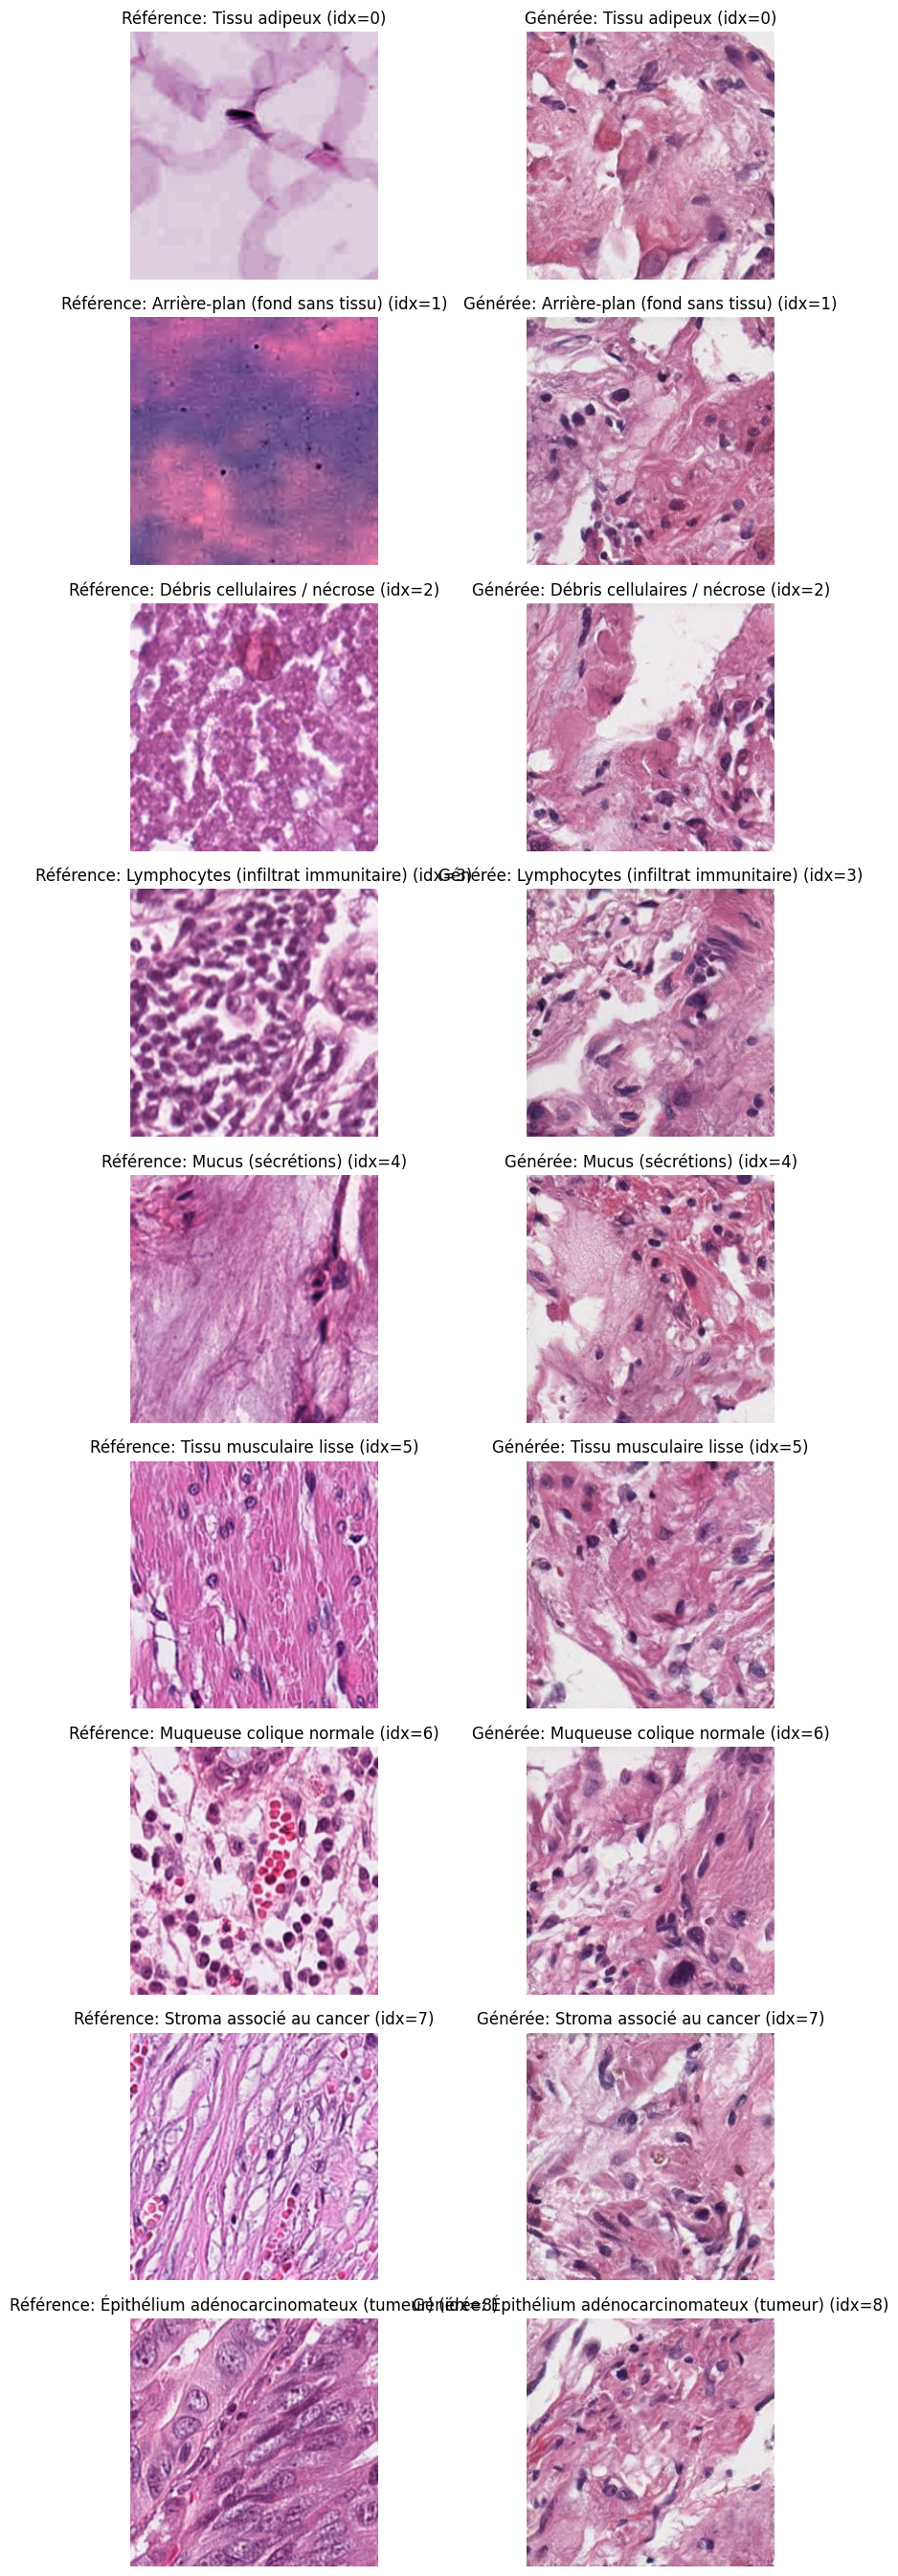


📊 Résumé: 9 images générées (une par classe)
   Classes: ['Tissu adipeux', 'Arrière-plan (fond sans tissu)', 'Débris cellulaires / nécrose', 'Lymphocytes (infiltrat immunitaire)', 'Mucus (sécrétions)', 'Tissu musculaire lisse', 'Muqueuse colique normale', 'Stroma associé au cancer', 'Épithélium adénocarcinomateux (tumeur)']


In [ ]:
# %% ✨ Mini-génération (2-4 images depuis train_loader, sauvegarde PNG)
# Charge le modèle optimal depuis MODELS_DIR
import torch
from PIL import Image
import numpy as np
from pathlib import Path
import os

# Config
N_GEN = 4  # Nombre d'images à générer
GUIDANCE_SCALE = 2  # Paramètres originaux (retour à la configuration de base)
NUM_INFERENCE_STEPS = 35  # Paramètres originaux (retour à la configuration de base)
SEED = 123

# Vérifications
assert "dl_vis" in globals() or "train_loader" in globals(), "DataLoader introuvable"
assert "adapter" in globals(), "adapter introuvable"
assert "_pipe" in globals() or "pipe" in globals(), "Pipeline introuvable"

# === Charger le modèle optimal depuis MODELS_DIR ===
_pipe_local = globals().get("_pipe") or globals().get("pipe")

# Définir les chemins
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
if "MODELS_DIR" not in globals():
    MODELS_DIR = PROJECT_ROOT / "models"

# Chercher le modèle optimal (pixcell_uni2h_adapter_lora_optimal_step*.pt)
optimal_model = None
if MODELS_DIR.exists():
    optimal_models = list(MODELS_DIR.glob("pixcell_uni2h_adapter_lora_optimal_step*.pt"))
    if optimal_models:
        # Trier par date de modification (le plus récent en dernier)
        optimal_models.sort(key=lambda p: p.stat().st_mtime)
        optimal_model = optimal_models[-1]
        print(f"📌 Modèle optimal trouvé: {optimal_model.name}")
        
        # Charger le modèle optimal
        try:
            ckpt = torch.load(optimal_model, map_location="cpu", weights_only=False)
            
            # Charger l'adapter
            adapter.load_state_dict(ckpt["adapter"], strict=True)
            
            # Charger les LoRA dans le backbone
            if "lora" in ckpt and len(ckpt["lora"]) > 0:
                backbone_to_load = None
                if "BACKBONE" in globals():
                    backbone_to_load = BACKBONE
                elif _pipe_local is not None:
                    backbone_to_load = getattr(_pipe_local, "transformer", None) or getattr(_pipe_local, "unet", None)
                
                if backbone_to_load is not None:
                    try:
                        backbone_state = backbone_to_load.state_dict()
                        for key, value in ckpt["lora"].items():
                            if key in backbone_state:
                                backbone_state[key] = value.to(backbone_state[key].device)
                        backbone_to_load.load_state_dict(backbone_state, strict=False)
                        print(f"✅ LoRA chargées ({len(ckpt['lora'])} paramètres)")
                    except Exception as e:
                        print(f"⚠️ Erreur lors du chargement des LoRA: {e}")
                        print(f"   → Adapter chargé, LoRA ignorées")
            
            step_loaded = ckpt.get("step", None)
            optimal_loss = ckpt.get("optimal_loss", None)
            print(f"✅ Modèle optimal chargé:")
            print(f"   - Step: {step_loaded}")
            if optimal_loss is not None:
                print(f"   - Loss minimale: {optimal_loss:.4f}")
        except Exception as e:
            print(f"❌ Erreur lors du chargement du modèle optimal: {e}")
            print(f"   → Utilisation du modèle actuel")
    else:
        print(f"⚠️ Aucun modèle optimal trouvé dans {MODELS_DIR}")
        print(f"   → Utilisation du modèle actuel")
        print(f"   💡 Exécutez d'abord la cellule de sauvegarde du modèle optimal")
else:
    print(f"⚠️ Dossier MODELS_DIR introuvable: {MODELS_DIR}")
    print(f"   → Utilisation du modèle actuel")

# === Récupérer un exemple de CHAQUE classe (au lieu d'un batch aléatoire) ===
# Récupérer les mappings de classes
idx_to_name_global = globals().get("idx_to_name", {})
if not idx_to_name_global and "ds" in globals() and hasattr(globals()["ds"], 'class_to_idx'):
    from p9dg.utils.class_mappings import make_idx_mappings
    idx_to_name_global, _, _ = make_idx_mappings(globals()["ds"].class_to_idx)

# Récupérer toutes les classes disponibles
if "ds" in globals() and hasattr(globals()["ds"], 'class_to_idx'):
    all_classes = sorted(globals()["ds"].class_to_idx.values())  # Liste des indices de classes
    print(f"📋 {len(all_classes)} classes disponibles: {[idx_to_name_global.get(c, f'Class_{c}') for c in all_classes]}")
else:
    # Fallback: utiliser N_GEN classes si on ne peut pas récupérer la liste
    all_classes = list(range(N_GEN))
    print(f"⚠️ Impossible de récupérer les classes du dataset, génération de {N_GEN} images")

pils_ref = []
ys_ref = []
paths_ref = []

if "dl_vis" in globals():
    # Parcourir dl_vis pour trouver un exemple de chaque classe
    class_found = set()  # Classes déjà trouvées
    dl_iter = iter(dl_vis)
    
    # Essayer plusieurs batches jusqu'à trouver toutes les classes
    max_iterations = 100  # Limite pour éviter une boucle infinie
    iteration = 0
    
    while len(class_found) < len(all_classes) and iteration < max_iterations:
        try:
            pils_batch, xs_batch, ys_batch, paths_batch = next(dl_iter)
        except StopIteration:
            dl_iter = iter(dl_vis)  # Réinitialiser l'itérateur
            continue
        
        # Parcourir le batch pour trouver de nouvelles classes
        for i in range(len(pils_batch)):
            class_idx = int(ys_batch[i].item() if hasattr(ys_batch[i], 'item') else ys_batch[i])
            if class_idx not in class_found and class_idx in all_classes:
                pils_ref.append(pils_batch[i])
                ys_ref.append(class_idx)
                paths_ref.append(paths_batch[i] if i < len(paths_batch) else f"class_{class_idx}")
                class_found.add(class_idx)
                
                # Afficher la progression
                class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
                print(f"  ✓ Trouvé: classe {class_idx} ({class_name})")
                
                # Si toutes les classes sont trouvées, arrêter
                if len(class_found) >= len(all_classes):
                    break
        
        iteration += 1
    
    # Si on n'a pas trouvé toutes les classes, afficher un avertissement
    if len(class_found) < len(all_classes):
        missing = set(all_classes) - class_found
        print(f"⚠️ Classes non trouvées dans le dataloader: {missing}")
        print(f"   Génération de {len(pils_ref)} images pour {len(class_found)} classes trouvées")
    
    # Convertir ys_ref en tensor
    ys_ref = torch.tensor(ys_ref) if len(ys_ref) > 0 else torch.tensor([])
    
else:
    # Fallback sur train_loader (pas de labels disponibles) - prendre N_GEN images aléatoires
    print("⚠️ dl_vis non disponible, utilisation de train_loader (pas de sélection par classe)")
    x_batch = next(iter(train_loader))[:N_GEN]
    pils_ref = []
    ys_ref = []  # Pas de labels disponibles depuis train_loader
    for i in range(x_batch.size(0)):
        x01 = (x_batch[i] + 1.0) / 2.0
        arr = (x01.permute(1, 2, 0).cpu().numpy() * 255.0).astype(np.uint8)
        pils_ref.append(Image.fromarray(arr).convert("RGB"))
    ys_ref = torch.tensor([-1] * len(pils_ref))  # Labels inconnus

print(f"\n🎨 Génération de {len(pils_ref)} images (une par classe)...")
# Afficher les classes qui seront générées
if len(ys_ref) > 0:
    try:
        classes_ref = []
        for y in ys_ref:
            class_idx = int(y.item() if hasattr(y, 'item') else y)
            if class_idx >= 0:
                class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
                classes_ref.append(f"{class_name} (idx={class_idx})")
            else:
                classes_ref.append("Unknown")
        print(f"   Classes à générer: {classes_ref}")
    except Exception as e:
        print(f"   ⚠️ Erreur lors de l'affichage des classes: {e}")

# Génération image par image (la pipeline PixCell attend exactement 1 embedding UNI par appel)
gen_images = []
# _pipe_local déjà défini au début de la cellule

print(f"   Génération de {len(pils_ref)} images (une par une)...")
for i, pil_ref in enumerate(pils_ref):
    # Extraire embedding UNI pour cette image seule
    with torch.inference_mode():
        pos_uni = uni_embeds_for_pixcell([pil_ref])  # [1, 1, 1536]
        
        # Appliquer l'adapter directement sur l'embedding UNI
        with torch.amp.autocast(device_type="cuda", enabled=False):  # Adapter en FP32
            pos_uni_adapted = adapter(pos_uni.float()).to(dtype=MODEL_DTYPE)  # [1, 1, 1536]
        
        # Embedding négatif (unconditional)
        neg_uni = _pipe_local.get_unconditional_embedding(1)  # [1, 1, 1536]
        if neg_uni.ndim == 2:
            neg_uni = neg_uni.unsqueeze(1)
        # Adapter aussi le négatif
        with torch.amp.autocast(device_type="cuda", enabled=False):
            neg_uni_adapted = adapter(neg_uni.float()).to(dtype=MODEL_DTYPE)
    
    # Génération pour cette image seule
    generator = torch.Generator(device=device).manual_seed(SEED + i)  # Seed différent par image
    
    with torch.autocast(device_type="cuda", enabled=True, dtype=MODEL_DTYPE):
        out = _pipe_local(
            uni_embeds=pos_uni_adapted,
            negative_uni_embeds=neg_uni_adapted,
            guidance_scale=GUIDANCE_SCALE,
            num_inference_steps=NUM_INFERENCE_STEPS,
            num_images_per_prompt=1,
            generator=generator,
            height=256,
            width=256,
            output_type="pil",
        )
    gen_img = out.images[0] if hasattr(out, "images") else out[0]
    gen_images.append(gen_img)
    
    if (i + 1) % 2 == 0 or (i + 1) == len(pils_ref):
        print(f"   ✓ {i + 1}/{len(pils_ref)} images générées")

# Sauvegarder les images (nommées par classe)
if optimal_model is not None:
    # Extraire le step du nom du fichier du modèle optimal
    import re
    match = re.search(r'step(\d+)', optimal_model.name)
    step_str = f"optimal_step{match.group(1)}" if match else "optimal"
else:
    step_str = f"step{global_step:06d}" if "global_step" in globals() else "current"

# Créer le répertoire si nécessaire
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
if "SAMPLES_DIR" not in globals():
    SAMPLES_DIR = PROJECT_ROOT / "samples" / "08_uni2h_adapter_lora"
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

for i, (ref_pil, gen_pil) in enumerate(zip(pils_ref, gen_images)):
    # Nom de fichier incluant la classe si disponible
    if i < len(ys_ref):
        try:
            class_idx = int(ys_ref[i].item() if hasattr(ys_ref[i], 'item') else ys_ref[i])
            if class_idx >= 0:
                class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
                # Nettoyer le nom de classe pour le fichier (enlever caractères spéciaux)
                class_name_clean = "".join(c if c.isalnum() or c in (' ', '-', '_') else '_' for c in class_name).strip().replace(' ', '_')
                file_suffix = f"class{class_idx:02d}_{class_name_clean}"
            else:
                file_suffix = f"class{i:02d}"
        except Exception:
            file_suffix = f"class{i:02d}"
    else:
        file_suffix = f"class{i:02d}"
    
    # Référence
    ref_path = SAMPLES_DIR / f"{step_str}_ref_{file_suffix}.png"
    ref_pil.save(ref_path)
    # Générée
    gen_path = SAMPLES_DIR / f"{step_str}_gen_{file_suffix}.png"
    gen_pil.save(gen_path)

print(f"\n✅ {len(gen_images)} images sauvegardées dans {SAMPLES_DIR}/")
print(f"   Format: {step_str}_ref_class*_*.png (référence) et {step_str}_gen_class*_*.png (générée)")
print(f"   Une image par classe générée")

# Afficher un aperçu (optionnel)
try:
    import matplotlib.pyplot as plt
    # Récupérer les mappings de classes si disponibles
    idx_to_name_global = globals().get("idx_to_name", {})
    if not idx_to_name_global and "ds" in globals() and hasattr(ds, 'class_to_idx'):
        from p9dg.utils.class_mappings import make_idx_mappings
        idx_to_name_global, _, _ = make_idx_mappings(ds.class_to_idx)
    
    # Afficher TOUTES les images générées (une par classe)
    n_show = len(pils_ref)  # Afficher toutes les images, pas seulement 4
    fig, axes = plt.subplots(n_show, 2, figsize=(10, 3*n_show))  # Taille adaptée au nombre d'images
    if n_show == 1:
        axes = axes.reshape(1, -1)
    
    # Utiliser ys_ref directement (défini plus haut dans la cellule)
    for i in range(n_show):
        # Titre avec classe pour l'image de référence
        if i < len(ys_ref) and len(ys_ref) > 0:
            try:
                class_idx = int(ys_ref[i].item() if hasattr(ys_ref[i], 'item') else ys_ref[i])
                if class_idx >= 0:
                    class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
                    ref_title = f"Référence: {class_name} (idx={class_idx})"
                else:
                    ref_title = "Référence"
            except Exception:
                ref_title = "Référence"
        else:
            ref_title = "Référence"
        
        # S'assurer que les images sont bien en RGB et correctement formatées
        ref_img = pils_ref[i]
        if not isinstance(ref_img, Image.Image):
            ref_img = Image.fromarray(np.array(ref_img))
        if ref_img.mode != "RGB":
            ref_img = ref_img.convert("RGB")
        
        gen_img = gen_images[i]
        if not isinstance(gen_img, Image.Image):
            gen_img = Image.fromarray(np.array(gen_img))
        if gen_img.mode != "RGB":
            gen_img = gen_img.convert("RGB")
        
        axes[i, 0].imshow(ref_img)
        axes[i, 0].set_title(ref_title)
        axes[i, 0].axis("off")
        axes[i, 1].imshow(gen_img)
        # Titre avec classe pour l'image générée aussi
        if i < len(ys_ref) and len(ys_ref) > 0:
            try:
                class_idx = int(ys_ref[i].item() if hasattr(ys_ref[i], 'item') else ys_ref[i])
                if class_idx >= 0:
                    class_name = idx_to_name_global.get(class_idx, f"Class_{class_idx}")
                    gen_title = f"Générée: {class_name} (idx={class_idx})"
                else:
                    gen_title = f"Générée (step {step_str})"
            except Exception:
                gen_title = f"Générée (step {step_str})"
        else:
            gen_title = f"Générée (step {step_str})"
        axes[i, 1].set_title(gen_title)
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()
    
    # Afficher le résumé des classes générées
    if len(ys_ref) > 0:
        try:
            classes_batch = []
            for y in ys_ref:  # Afficher toutes les classes, pas seulement n_show
                class_idx = int(y.item() if hasattr(y, 'item') else y)
                if class_idx >= 0:
                    classes_batch.append(idx_to_name_global.get(class_idx, f"Class_{class_idx}"))
                else:
                    classes_batch.append("Unknown")
            print(f"\n📊 Résumé: {len(classes_batch)} images générées (une par classe)")
            print(f"   Classes: {classes_batch}")
        except Exception:
            pass
except Exception as e:
    print(f"⚠️ Affichage matplotlib ignoré: {e}")
    import traceback
    traceback.print_exc()


## 🔄 Cellule F — Re-load quick test


🔄 Rechargement du checkpoint: checkpoints/08_adapter/adapter_lora_step000050.pt
✓ Adapter rechargé (7 clés)
✓ LoRA rechargées (252/252 clés)

🧪 Test de génération avec checkpoint rechargé...


/tmp/ipykernel_22541/3493664943.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(CHECKPOINT_PATH, map_location="cpu")


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Génération réussie avec checkpoint rechargé
💾 Image de test sauvegardée: artifacts/mini_samples/reload_test.png


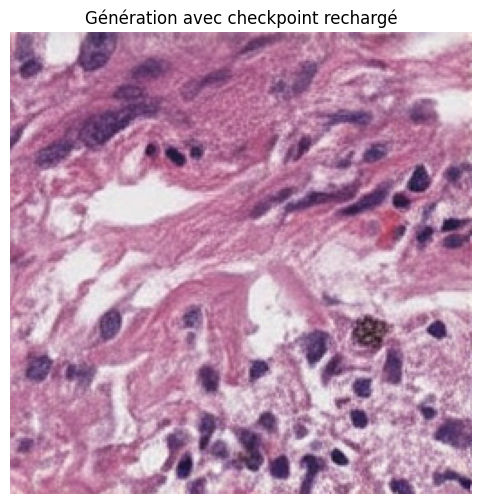

In [ ]:
# %% 🔄 Re-load quick test (recharger modèle optimal Adapter+LoRA et regénérer 1 image)
import torch
from pathlib import Path
import os
from PIL import Image
import numpy as np

# Chemin du modèle (par défaut: modèle optimal dans MODELS_DIR)
# Vous pouvez spécifier un autre chemin si nécessaire
MODEL_PATH = None  # None = cherche le modèle optimal dans MODELS_DIR

# Définir les chemins
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
if "MODELS_DIR" not in globals():
    MODELS_DIR = PROJECT_ROOT / "models"

# Si MODEL_PATH n'est pas spécifié, chercher le modèle optimal dans MODELS_DIR
if MODEL_PATH is None:
    if MODELS_DIR.exists():
        optimal_models = list(MODELS_DIR.glob("pixcell_uni2h_adapter_lora_optimal_step*.pt"))
        if optimal_models:
            # Trier par date de modification (le plus récent en dernier)
            optimal_models.sort(key=lambda p: p.stat().st_mtime)
            MODEL_PATH = optimal_models[-1]
            print(f"📌 Modèle optimal trouvé: {MODEL_PATH.name}")
        else:
            print(f"⚠️ Aucun modèle optimal trouvé dans {MODELS_DIR}")
            print(f"   💡 Exécutez d'abord la cellule de sauvegarde du modèle optimal")
            MODEL_PATH = None
    else:
        print(f"⚠️ Dossier MODELS_DIR introuvable: {MODELS_DIR}")
        MODEL_PATH = None
else:
    MODEL_PATH = Path(MODEL_PATH)
    if not MODEL_PATH.exists():
        print(f"⚠️ Chemin spécifié introuvable: {MODEL_PATH}")
        MODEL_PATH = None

if MODEL_PATH and MODEL_PATH.exists():
    print(f"🔄 Rechargement du modèle: {MODEL_PATH.name}")
    
    # Charger l'état
    state = torch.load(MODEL_PATH, map_location="cpu", weights_only=False)
    
    # Afficher les informations du modèle
    step_loaded = state.get("step", None)
    optimal_loss = state.get("optimal_loss", None)
    if step_loaded is not None:
        print(f"   - Step: {step_loaded}")
    if optimal_loss is not None:
        print(f"   - Loss minimale: {optimal_loss:.4f}")
    
    # 1) Recharger Adapter
    adapter.load_state_dict(state["adapter"], strict=True)
    adapter.to(device)
    print(f"✓ Adapter rechargé ({len(state['adapter'])} clés)")
    
    # 2) Recharger LoRA dans le backbone
    if "lora" in state and len(state["lora"]) > 0:
        loaded_lora = 0
        backbone_to_load = None
        if "BACKBONE" in globals():
            backbone_to_load = BACKBONE
        elif "_pipe" in globals() or "pipe" in globals():
            _pipe_local = globals().get("_pipe") or globals().get("pipe")
            if _pipe_local is not None:
                backbone_to_load = getattr(_pipe_local, "transformer", None) or getattr(_pipe_local, "unet", None)
        
        if backbone_to_load is not None:
            backbone_state = backbone_to_load.state_dict()
            for key, tensor in state["lora"].items():
                if key in backbone_state:
                    backbone_state[key] = tensor.to(backbone_state[key].device)
                    loaded_lora += 1
            backbone_to_load.load_state_dict(backbone_state, strict=False)
            print(f"✓ LoRA rechargées ({loaded_lora}/{len(state['lora'])} clés)")
        else:
            print(f"⚠️ Backbone introuvable, LoRA non chargées")
    else:
        print(f"⚠️ Aucune LoRA trouvée dans le modèle")
    
    # 3) Test de génération rapide
    print("\n🧪 Test de génération avec checkpoint rechargé...")
    
    # Une image de test
    test_pil = Image.fromarray(np.random.randint(0, 255, (256, 256, 3), dtype=np.uint8))
    
    with torch.inference_mode():
        # Extraire embedding UNI pour cette image seule
        pos_uni = uni_embeds_for_pixcell([test_pil])  # [1, 1, 1536]
        
        # Appliquer l'adapter directement sur l'embedding UNI (pas encode_uni_to_ctx)
        with torch.amp.autocast(device_type="cuda", enabled=False):  # Adapter en FP32
            pos_uni_adapted = adapter(pos_uni.float()).to(dtype=MODEL_DTYPE)  # [1, 1, 1536]
        
        # Embedding négatif (unconditional)
        neg_uni = _pipe.get_unconditional_embedding(1)  # [1, 1, 1536]
        if neg_uni.ndim == 2:
            neg_uni = neg_uni.unsqueeze(1)
        # Adapter aussi le négatif
        with torch.amp.autocast(device_type="cuda", enabled=False):
            neg_uni_adapted = adapter(neg_uni.float()).to(dtype=MODEL_DTYPE)
        
        generator = torch.Generator(device=device).manual_seed(42)
        
        with torch.autocast(device_type="cuda", enabled=True, dtype=MODEL_DTYPE):
            out = _pipe(
                uni_embeds=pos_uni_adapted,
                negative_uni_embeds=neg_uni_adapted,
                guidance_scale=1.5,  # Paramètres originaux
                num_inference_steps=20,  # Paramètres originaux
                num_images_per_prompt=1,
                generator=generator,
                height=256,
                width=256,
                output_type="pil",
            )
            gen_img = out.images[0] if hasattr(out, "images") else out[0]
            print("✅ Génération réussie avec checkpoint rechargé")
            
            # Sauvegarder
            if "SAMPLES_DIR" not in globals():
                if "PROJECT_ROOT" not in globals():
                    PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
                SAMPLES_DIR = PROJECT_ROOT / "samples" / "08_uni2h_adapter_lora"
            SAMPLES_DIR.mkdir(parents=True, exist_ok=True)
            test_path = SAMPLES_DIR / "reload_test.png"
            gen_img.save(test_path)
            print(f"💾 Image de test sauvegardée: {test_path}")
            
            # Afficher
            try:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(6, 6))
                plt.imshow(gen_img)
                plt.title("Génération avec checkpoint rechargé")
                plt.axis("off")
                plt.show()
            except:
                pass
else:
    print("⚠️ Aucun modèle à recharger.")
    print("   💡 Options:")
    print("   - Exécutez d'abord la cellule de sauvegarde du modèle optimal")
    print("   - Ou spécifiez MODEL_PATH manuellement (ex: MODEL_PATH = 'path/to/model.pt')")
